# Introduction

The goal of this notebook is testing how long it takes to solve problems with conlloovia depending on the size of the problem. In addition, it compares conlloovia and the heuristic allocators, using two sets of parameters:
- Unrestricted mode: random parameters
- Restricted mode: parameters constrained to the cases where the first-fit allocator based on size works best.

There are five allocators:

- Conlloovia. The allocator based on the integer linear programming solver.
- Greedy. An allocator that starts by allocating the cheapest instance classes first.
- First-fit. An allocator that starts by allocating the biggest instance classes first. It should be deprecated.
- First-fit 2 cores desc. A new implementation with some different details of the first-fit allocator. It should be the one to use.
- First-fit 2 price asc. This should be similar to Greedy.

In [1]:
import random
import dataclasses
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

sns.set_style("whitegrid")
from pulp import PULP_CBC_CMD
from rich.live import Live
from rich.table import Table
from rich import print

from cloudmodel.unified.units import (
    ComputationalUnits,
    CurrencyPerTime,
    Time,
    Requests,
    RequestsPerTime,
    Storage,
)

from conlloovia import (
    Problem,
    App,
    InstanceClass,
    ContainerClass,
    System,
    Workload,
    ConllooviaAllocator,
    Status,
    Solution,
)
from conlloovia.greedy import GreedyAllocator
from conlloovia.first_fit import (
    FirstFitAllocator,
    FirstFitAllocator2,
    FirstFitIcOrdering,
)


In [2]:
def create_problem(
    n_apps: int, n_ics: int, limit_ics: int, n_ccs: int, limit_ccs: int
) -> Problem:
    """This functions creates a problem with random values. It tries to generate
    a feasible problem, but it's not guaranteed. In addition, it tries to avoid
    unreasonable values, like a container class with more cores than the most
    powerful instance class.

    Args:
        n_apps (int): Number of applications
        n_ics (int): Number of instance classes
        limit_ics (int): Limit of instance classes
        n_ccs (int): Number of container classes per application
        limit_ccs (int): Limit of container classes per application

    Returns:
        Problem: The problem created
    """

    # Create the apps
    apps = tuple(App(name=f"app{a}") for a in range(n_apps))

    # Base price of a core and a gibibyte of memory
    price_core = 0.25
    price_mem_gb = 0.1

    # The maximum number of cores and memory of all the instance classes.
    max_cores = 0
    max_mem_gb = 0

    # Cores and memory of the most powerful machine. The idea is that
    # no container should have more cores and memory than the maximum
    # configuration
    max_conf = (0, 0)

    # Create the instance classes
    ic_list = []
    for i in range(n_ics):
        cores = random.choice([2, 4, 8, 16, 32, 64])

        # Update max_cores
        if cores > max_cores:
            max_cores = cores

        # The memory is proportional to the number of cores
        mem_multiplier = random.choice([1, 2, 4])
        mem_gb = cores * mem_multiplier

        # Update max_mem_gb
        if mem_gb > max_mem_gb:
            max_mem_gb = mem_gb

        # Update max_conf
        if cores >= max_conf[0] and mem_gb > max_conf[1]:
            max_conf = (cores, mem_gb)

        # The price is a random value around the price of the cores and memory
        price = random.gauss(cores * price_core + mem_gb * price_mem_gb, 0.2)

        ic_list.append(
            InstanceClass(
                name=f"ic_{i}",
                price=CurrencyPerTime(f"{price} usd/hour"),
                cores=ComputationalUnits(f"{cores} cores"),
                mem=Storage(f"{mem_gb} gibibytes"),
                limit=limit_ics,
            )
        )
    ics = tuple(ic_list)

    # Set the maximum number of cores and memory of a container class. The max
    # are divided by n_apps to allow to have at least one core per app
    max_cores_per_app = max(1, max_cores // n_apps)  # At least 1
    max_mem_gb_per_app = max(1, max_mem_gb // n_apps)  # At least 1
    max_conf_cores_per_app = max(1, max_conf[0] // n_apps)  # At least 1
    max_mem_gb_per_app = max(1, max_conf[1] // n_apps)  # At least 1

    # Create the container classes
    cc_list = []
    for app in apps:
        for i in range(n_ccs):
            cores = min(
                random.choice([0.25, 0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_cores_per_app,
                max_conf_cores_per_app,
            )
            mem = min(
                random.choice([0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_mem_gb_per_app,
                max_mem_gb_per_app,
            )

            cc_list.append(
                ContainerClass(
                    name=f"cc_{app.name}_{i}",
                    cores=ComputationalUnits(f"{cores} cores"),
                    mem=Storage(f"{mem} gibibytes"),
                    app=app,
                    limit=limit_ccs,
                )
            )

    ccs = tuple(cc_list)

    # Generate a random base performance for each app
    perf_base = {}
    for app in apps:
        perf_base[app] = random.randrange(1, 1000)

    # Create the workloads
    workloads = {}
    for app in apps:
        # It starts with 2 because we don't want the maximum value to be 1:
        # randrange(1, 1) would give an error
        max_workload_h = (2 + perf_base[app] * n_ics * limit_ics // n_apps) * 3600
        workloads[app] = Workload(
            num_reqs=Requests(f"{random.randrange(1, max_workload_h)} req"),
            time_slot_size=Time("hour"),
            app=app,
        )

    # Create the performances
    perfs = {}
    for ic in ics:
        for cc in ccs:
            rps = random.gauss(10 * perf_base[cc.app], 0.1) * cc.cores.magnitude
            perfs[(ic, cc)] = RequestsPerTime(f"{rps} req/s")

    system = System(apps=apps, ics=ics, ccs=ccs, perfs=perfs)

    return Problem(system=system, workloads=workloads, sched_time_size=Time("hour"))


def create_restricted_problem(
    n_apps: int, n_ics: int, limit_ics: int, n_ccs: int, limit_ccs: int
) -> Problem:
    """This function creates a problem with a set of restrictions that are the
    basic assumptions followed wheen creating the first fit allocator. They are:

    - The performance of the container classes for an application only depends
      on the number of cores used.

    - All the container classes for an application have a number of cores that
      is multiple of the number of cores of the least powerful container class.

    - The capacity in cores of an instance class is a power of two.

    - The cost of an instance class is proportional to the number of cores.

    - Memory is not an issue. To simulate this, the memory of all container
      classes is set to 0 gibibytes.

    Args:
        n_apps (int): Number of applications
        n_ics (int): Number of instance classes
        limit_ics (int): Limit of instance classes
        n_ccs (int): Number of container classes per application
        limit_ccs (int): Limit of container classes per application

    Returns:
        Problem: The problem created
    """

    # Create the apps
    apps = tuple(App(name=f"app{a}") for a in range(n_apps))

    # Base price of a core
    price_core = 0.25

    max_cores = 0

    ic_list = []
    for i in range(n_ics):
        cores = random.choice([2, 4, 8, 16, 32, 64])
        if cores > max_cores:
            max_cores = cores

        price = cores * price_core
        ic_list.append(
            InstanceClass(
                name=f"ic_{i}",
                price=CurrencyPerTime(f"{price} usd/hour"),
                cores=ComputationalUnits(f"{cores} cores"),
                mem=Storage(f"0 gibibytes"),
                limit=limit_ics,
            )
        )
    ics = tuple(ic_list)

    # The max are divided by n_apps to allow to have at least one core per app
    max_cores_per_app = max(1, max_cores // n_apps)  # At least 1

    cc_list = []
    for app in apps:
        for i in range(n_ccs):
            cores = min(
                random.choice([0.25, 0.5, 1, 1.5, 2, 2.5, 4, 8, 16, 32, 64]),
                max_cores_per_app,
            )

            cc_list.append(
                ContainerClass(
                    name=f"cc_{app.name}_{i}",
                    cores=ComputationalUnits(f"{cores} cores"),
                    mem=Storage(f"0 gibibytes"),
                    app=app,
                    limit=limit_ccs,
                )
            )

    ccs = tuple(cc_list)

    # Generate a random base performance for each app
    perf_base = {}
    for app in apps:
        perf_base[app] = random.randrange(1, 1000)

    # Create the workloads
    workloads = {}
    for app in apps:
        # It starts with 2 because we don't want the maximum value to be 1:
        # randrange(1, 1) would give an error
        max_workload_h = (2 + perf_base[app] * n_ics * limit_ics // n_apps) * 3600
        workloads[app] = Workload(
            num_reqs=Requests(f"{random.randrange(1, max_workload_h)} req"),
            time_slot_size=Time("hour"),
            app=app,
        )

    # Create the performances
    perfs = {}
    for ic in ics:
        for cc in ccs:
            rps = perf_base[cc.app] * cc.cores.to("cores").magnitude
            perfs[(ic, cc)] = RequestsPerTime(f"{rps} req/s")

    system = System(apps=apps, ics=ics, ccs=ccs, perfs=perfs)

    return Problem(system=system, workloads=workloads, sched_time_size=Time("hour"))


def run_exp(
    n_apps,
    n_ics,
    limit_ics,
    n_ccs,
    limit_ccs,
    restricted,
    solver,
    allocator_names,
    allocator_cls,
    allocator_kwargs,
) -> Tuple[Solution, ...]:
    """Solves the problem with the allocators indicated in the allocator_cls and
    returns the solutions. If restricted is True, the problem is created with
    the restrictions of the first fit allocator."""
    if restricted:
        problem = create_restricted_problem(n_apps, n_ics, limit_ics, n_ccs, limit_ccs)
    else:
        problem = create_problem(n_apps, n_ics, limit_ics, n_ccs, limit_ccs)

    sols = {}  # Dictionary with the solutions for each allocator
    for allocator_name, allocator_cl, kwargs in zip(
        allocator_names, allocator_cls, allocator_kwargs
    ):
        alloc = allocator_cl(problem, **kwargs)

        if allocator_name == "conlloovia":
            sol = alloc.solve(solver)
        else:
            sol = alloc.solve()

        sols[allocator_name] = sol

    return sols


def dec2(f: float):
    """Returns a string with two decimals."""
    return f"{f:.2f}"


def run_exp_and_update_stats(
    n_exp,
    n_apps,
    n_ics,
    limit_ics,
    n_ccs,
    limit_ccs,
    restricted,
    solver,
    allocators,
    allocator_cls,
    allocator_kwargs,
    stats,
    sols,
):
    """Runs an experiment and updates the stats dictionary."""

    # Compute the number of variables
    n_vars_x = n_ics * limit_ics
    n_vars_y = n_vars_x * n_apps * n_ccs
    n_vars_total = n_vars_x + n_vars_y

    # Run the experiment until it's feasible
    while True:
        sols_exp = run_exp(
            n_apps,
            n_ics,
            limit_ics,
            n_ccs,
            limit_ccs,
            restricted,
            solver,
            allocators,
            allocator_cls,
            allocator_kwargs,
        )
        if sols_exp["conlloovia"].solving_stats.status != Status.INFEASIBLE:
            break
        print("The experiment was INFEASIBLE. Running again")

    # Save the solutions and the stats
    for allocator, sol in sols_exp.items():
        sols[allocator][n_exp] = sol
        stats[allocator][n_exp] = dataclasses.asdict(sol.solving_stats)
        stats[allocator][n_exp]["num_vars"] = n_vars_total
        stats[allocator][n_exp]["cost"] = sol.cost.to("usd").magnitude

    # For conlloovia, compute the gap percentage if the solution is feasible
    if sols_exp["conlloovia"].solving_stats.status == Status.INTEGER_FEASIBLE:
        bound = stats["conlloovia"][n_exp]["lower_bound"]
        cost_magnitude = sols_exp["conlloovia"].cost.to("usd").magnitude
        stats["conlloovia"][n_exp]["gap_pct"] = (
            100 * (cost_magnitude - bound) / cost_magnitude
        )

        if bound == 0:
            print("Warning: lower bound is 0")

        if stats["conlloovia"][n_exp]["gap_pct"] < 0:
            print("Warning: gap_pct negative (the bound is bigger than the cost)")
    else:
        stats["conlloovia"][n_exp]["gap_pct"] = 0

    # For the other allocators, set the gap percentage to 0
    for allocator in allocators:
        if allocator != "conlloovia":
            stats[allocator][n_exp]["gap_pct"] = 0

    return n_vars_x, n_vars_y, n_vars_total


def run(restricted: bool):
    """Runs the experiments. If restricted is True, the problem is created with
    the restrictions of the first fit allocator."""

    # Set the seed to be able to reproduce the experiments
    random.seed(100)

    # The commented values are alternative values that can be used to run more
    # experiments
    range_apps = [1, 8, 32]  # [1, 2, 4, 8, 16, 32]
    range_ics = [1, 4, 16]  # [1, 2, 4, 8, 16]
    range_limit_ics = [1, 20, 50]  # [1, 10, 20, 50]
    range_ccs = [1, 2, 8]  # [1, 2, 4, 8]

    # Set the limit of container classes to a big number, greater than the
    # maximum number of cores in a instance class (64) divided by the smaller
    # number of cores in a container class (0.5)
    limit_ccs = 64 / 0.5

    # Uncomment the following lines to run a small experiment
    # print("TODO: remove")
    # range_apps = [1, 8]
    # range_ics = [1, 4]
    # range_limit_ics = [1, 20]
    # range_ccs = [1, 2]

    n_exp = 0  # Experiment number
    total_num_exps = (
        len(range_apps) * len(range_ics) * len(range_limit_ics) * len(range_ccs)
    )
    print(f"Num. experiments: {total_num_exps}")

    # Limit to 600 seconds the time of the solver and use 8 threads
    solver = PULP_CBC_CMD(timeLimit=600, threads=8, msg=False)

    allocators = [
        "conlloovia",
        "greedy",
        "first fit",
        "first fit 2 (cores desc)",
        "first fit 2 (price asc)",
    ]
    allocator_cls = [
        ConllooviaAllocator,
        GreedyAllocator,
        FirstFitAllocator,
        FirstFitAllocator2,
        FirstFitAllocator2,
    ]
    allocator_kwargs = [
        {},
        {},
        {},
        {"ordering": FirstFitIcOrdering.CORE_DESCENDING},
        {"ordering": FirstFitIcOrdering.PRICE_ASCENDING},
    ]

    stats = {i: {} for i in allocators}
    sols = {i: {} for i in allocators}

    # Create a table where each row has a summary of each experiment
    table = Table("Exp", "# vars")
    for allocator in allocators:
        table.add_column(f"{allocator} cost", justify="right")
    table.add_column("Conlloovia status", justify="right")
    table.add_column("Conlloovia sol. time", justify="right")

    # Use a live table to show the progress of the experiments as they run
    with Live(table, auto_refresh=False) as live:
        for n_apps in range_apps:
            for n_ics in range_ics:
                for limit_ics in range_limit_ics:
                    for n_ccs in range_ccs:
                        n_exp += 1

                        n_vars_x, n_vars_y, n_vars_total = run_exp_and_update_stats(
                            n_exp,
                            n_apps,
                            n_ics,
                            limit_ics,
                            n_ccs,
                            limit_ccs,
                            restricted,
                            solver,
                            allocators,
                            allocator_cls,
                            allocator_kwargs,
                            stats,
                            sols,
                        )

                        table_params = []
                        for allocator in allocators:
                            param_cell = dec2(stats[allocator][n_exp]["cost"])

                            if allocator != "conlloovia":
                                diff_conlloovia = (
                                    stats[allocator][n_exp]["cost"]
                                    - stats["conlloovia"][n_exp]["cost"]
                                )
                                param_cell += f" ({diff_conlloovia:.2f})"

                            # Show the lower bound if it's greater than 0,
                            # which can only happen in conlloovia
                            lower_bound = stats[allocator][n_exp]["lower_bound"]
                            if lower_bound and lower_bound > 0:
                                bound = dec2(lower_bound)
                                param_cell += f"/{bound}"

                            table_params.append(param_cell)

                        table_params.append(
                            str(stats["conlloovia"][n_exp]["status"].name)
                        )
                        table_params.append(
                            dec2(stats["conlloovia"][n_exp]["solving_time"])
                        )

                        table.add_row(
                            str(n_exp),
                            str(n_vars_total),
                            *table_params,
                        )
                        live.refresh()

    print(
        f"Biggest experiment -> num X: {n_vars_x:,} num Y: {n_vars_y:,} total: {n_vars_total:,}"
    )
    print(f"num exps: {n_exp}")

    # Printing it again because the Live element doesn't work
    # when the notebook is loaded from disk
    print(table)

    # Save the stats in a CSV file
    file_name = "exp_size_restricted" if restricted else "exp_size_unrestricted"
    save_stats_csv(n_exp, allocators, stats, file_name)

    return sols, stats


def save_stats_csv(
    n_exp: int, allocators: list[str], stats: dict, file_name: str
) -> None:
    """Saves the stats in a CSV file.

    Args:
        n_exp (int): Number of experiments
        allocators (list[str]): List of allocators
        stats (dict): Dictionary with the stats
        file_name (str): Name of the file
    """
    headers = [
        "exp",
        "num_vars",
        *[f"{name} cost" for name in allocators],
        "conlloovia lower_bound",
        "conlloovia gap_pct",
        *[f"{name} status" for name in allocators],
        *[f"{name} creation_time" for name in allocators],
        *[f"{name} solving_time" for name in allocators],
        *[
            f"{name} cost diff conlloovia"
            for name in allocators
            if name != "conlloovia"
        ],
    ]
    df = pd.DataFrame(columns=headers)
    for n_exp in range(1, n_exp + 1):
        row = [n_exp, stats["conlloovia"][n_exp]["num_vars"]]
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["cost"])
        row.append(stats["conlloovia"][n_exp]["lower_bound"])
        row.append(stats["conlloovia"][n_exp]["gap_pct"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["status"].name)
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["creation_time"])
        for allocator in allocators:
            row.append(stats[allocator][n_exp]["solving_time"])
        for allocator in allocators:
            if allocator != "conlloovia":
                diff_conlloovia = (
                    stats[allocator][n_exp]["cost"] - stats["conlloovia"][n_exp]["cost"]
                )
                row.append(diff_conlloovia)
        df.loc[n_exp] = row

    df.to_csv(f"{file_name}.csv")


sols = {}
stats = {}

print("Running experiments without restrictions")
sols["unrestricted"], stats["unrestricted"] = run(restricted=False)

print("Running experiments with restrictions")
sols["restricted"], stats["restricted"] = run(restricted=True)


Running experiments without restrictions

Num. experiments: 81

Output()

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

The experiment was INFEASIBLE. Running again

Biggest experiment -> num X: 800 num Y: 204,800 total: 205,600

num exps: 81

┏━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃     ┃        ┃             ┃             ┃             ┃ first fit 2 ┃ first fit 2 ┃             ┃              ┃
┃     ┃        ┃  conlloovia ┃             ┃   first fit ┃      (cores ┃ (price asc) ┃  Conlloovia ┃   Conlloovia ┃
┃ Exp ┃ # vars ┃        cost ┃ greedy cost ┃        cost ┃  desc) cost ┃        cost ┃      status ┃    sol. time ┃
┡━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1   │ 2      │        1.47 │ 1.47 (0.00) │ 1.47 (0.00) │ 1.47 (0.00) │ 1.47 (0.00) │     OPTIMAL │         0.01 │
│ 2   │ 3      │        1.54 │ 1.54 (0.00) │ 1.54 (0.00) │ 1.54 (0.00) │ 1.54 (0.00) │     OPTIMAL │         0.01 │
│ 3   │ 9      │        1.72 │ 1.72 (0.00) │ 1.72 (0.00) │ 1.72 (0.00) │ 1.72 (0.00) │     OPTIMAL │         0.01 │
│ 4   │ 40     │       42.88 │       42.88 │       42.88 │       42.88 │       42.88 │     OPTIMAL │         0.06 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.00) │             │              │
│ 5   │ 60     │       28.73 │       28.73 │       28.73 │       28.73 │       28.73 │     OPTIMAL │         0.04 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.00) │             │              │
│ 6   │ 180    │        4.83 │ 4.83 (0.00) │ 4.83 (0.00) │ 4.83 (0.00) │ 4.83 (0.00) │     OPTIMAL │         0.06 │
│ 7   │ 100    │       43.15 │       43.15 │       43.15 │       43.15 │       43.15 │     OPTIMAL │         0.04 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.00) │             │              │
│ 8   │ 150    │        2.50 │       10.00 │       10.00 │       10.00 │       10.00 │     OPTIMAL │         0.08 │
│     │        │             │      (7.50) │      (7.50) │      (7.50) │      (7.50) │             │              │
│ 9   │ 450    │        2.80 │       17.74 │ 4.67 (1.87) │ 4.67 (1.87) │ 4.67 (1.87) │     OPTIMAL │         6.03 │
│     │        │             │     (14.94) │             │             │             │             │              │
│ 10  │ 8      │        3.68 │ 5.71 (2.02) │ 3.68 (0.00) │ 3.68 (0.00) │ 3.68 (0.00) │     OPTIMAL │         0.01 │
│ 11  │ 12     │       22.60 │       22.60 │       22.60 │       22.60 │       23.04 │     OPTIMAL │         0.01 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.45) │             │              │
│ 12  │ 36     │        1.62 │ 5.36 (3.74) │ 1.62 (0.00) │ 1.62 (0.00) │ 1.62 (0.00) │     OPTIMAL │         0.03 │
│ 13  │ 160    │        2.45 │ 2.45 (0.00) │ 2.45 (0.00) │ 2.45 (0.00) │ 2.45 (0.00) │     OPTIMAL │         0.03 │
│ 14  │ 240    │        2.98 │       22.83 │       20.77 │       20.77 │       20.77 │     OPTIMAL │         0.09 │
│     │        │             │     (19.85) │     (17.80) │     (17.80) │     (17.80) │             │              │
│ 15  │ 720    │        3.74 │       75.82 │       72.31 │       72.31 │       72.31 │     OPTIMAL │         0.19 │
│     │        │             │     (72.07) │     (68.57) │     (68.57) │     (68.57) │             │              │
│ 16  │ 400    │        7.31 │       14.14 │       10.12 │       10.12 │       10.12 │     OPTIMAL │         0.08 │
│     │        │             │      (6.83) │      (2.80) │      (2.80) │      (2.80) │             │              │
│ 17  │ 600    │        9.02 │      112.65 │      112.65 │      115.66 │      200.11 │     OPTIMAL │        26.63 │
│     │        │             │    (103.63) │    (103.63) │    (106.65) │    (191.09) │             │              │
│ 18  │ 1800   │        7.06 │      154.84 │      139.78 │      141.89 │      139.78 │     OPTIMAL │         0.37 │
│     │        │             │    (147.79) │    (132.72) │    (134.83) │    (132.72) │             │              │
│ 19  │ 32     │        5.02 │       30.99 │ 5.02 (0.00)

Running experiments with restrictions

Num. experiments: 81

Output()

The experiment was INFEASIBLE. Running again

Biggest experiment -> num X: 800 num Y: 204,800 total: 205,600

num exps: 81

┏━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃     ┃        ┃             ┃             ┃             ┃ first fit 2 ┃ first fit 2 ┃              ┃             ┃
┃     ┃        ┃  conlloovia ┃             ┃   first fit ┃      (cores ┃ (price asc) ┃   Conlloovia ┃  Conlloovia ┃
┃ Exp ┃ # vars ┃        cost ┃ greedy cost ┃        cost ┃  desc) cost ┃        cost ┃       status ┃   sol. time ┃
┡━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1   │ 2      │        1.00 │ 1.00 (0.00) │ 1.00 (0.00) │ 1.00 (0.00) │ 1.00 (0.00) │      OPTIMAL │        0.01 │
│ 2   │ 3      │        1.00 │ 1.00 (0.00) │ 1.00 (0.00) │ 1.00 (0.00) │ 1.00 (0.00) │      OPTIMAL │        0.01 │
│ 3   │ 9      │        0.50 │ 0.50 (0.00) │ 0.50 (0.00) │ 0.50 (0.00) │ 0.50 (0.00) │      OPTIMAL │        0.01 │
│ 4   │ 40     │        2.00 │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │      OPTIMAL │        0.02 │
│ 5   │ 60     │        2.00 │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │      OPTIMAL │        0.02 │
│ 6   │ 180    │        6.00 │ 6.00 (0.00) │ 6.00 (0.00) │ 6.00 (0.00) │ 6.00 (0.00) │      OPTIMAL │        0.02 │
│ 7   │ 100    │       16.00 │       16.00 │       16.00 │       16.00 │       16.00 │      OPTIMAL │        0.03 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.00) │              │             │
│ 8   │ 150    │        8.00 │ 8.00 (0.00) │ 8.00 (0.00) │ 8.00 (0.00) │ 8.00 (0.00) │      OPTIMAL │        0.03 │
│ 9   │ 450    │        9.00 │ 9.00 (0.00) │ 9.00 (0.00) │ 9.00 (0.00) │ 9.00 (0.00) │      OPTIMAL │        0.06 │
│ 10  │ 8      │        8.00 │ 8.00 (0.00) │ 8.00 (0.00) │ 8.00 (0.00) │       17.50 │      OPTIMAL │        0.01 │
│     │        │             │             │             │             │      (9.50) │              │             │
│ 11  │ 12     │        2.00 │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │ 8.00 (6.00) │      OPTIMAL │        0.01 │
│ 12  │ 36     │        2.00 │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │ 4.00 (2.00) │      OPTIMAL │        0.02 │
│ 13  │ 160    │       16.00 │       16.00 │       16.00 │       16.00 │       16.00 │      OPTIMAL │        0.03 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.00) │              │             │
│ 14  │ 240    │       14.00 │       14.00 │       14.00 │       14.00 │       14.00 │      OPTIMAL │        0.04 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │      (0.00) │              │             │
│ 15  │ 720    │        8.00 │ 8.00 (0.00) │ 8.00 (0.00) │ 8.00 (0.00) │ 8.00 (0.00) │      OPTIMAL │        0.09 │
│ 16  │ 400    │       22.00 │       33.00 │       24.00 │       24.00 │       33.00 │      OPTIMAL │        0.37 │
│     │        │             │     (11.00) │      (2.00) │      (2.00) │     (11.00) │              │             │
│ 17  │ 600    │       35.50 │       37.00 │       36.00 │       36.00 │       37.00 │      OPTIMAL │        0.11 │
│     │        │             │      (1.50) │      (0.50) │      (0.50) │      (1.50) │              │             │
│ 18  │ 1800   │        4.00 │ 4.00 (0.00) │ 4.00 (0.00) │ 4.00 (0.00) │ 4.00 (0.00) │      OPTIMAL │        0.29 │
│ 19  │ 32     │        2.00 │ 2.00 (0.00) │ 2.00 (0.00) │ 2.00 (0.00) │ 6.00 (4.00) │      OPTIMAL │        0.01 │
│ 20  │ 48     │        1.50 │ 2.00 (0.50) │ 2.00 (0.50) │ 2.00 (0.50) │ 2.00 (0.50) │      OPTIMAL │        0.03 │
│ 21  │ 144    │        3.50 │ 3.50 (0.00) │ 4.00 (0.50) │ 4.00 (0.50) │ 3.50 (0.00) │      OPTIMAL │        0.03 │
│ 22  │ 640    │       24.00 │       24.00 │       24.00 │       24.00 │      204.00 │      OPTIMAL │        0.12 │
│     │        │             │      (0.00) │      (0.00) │      (0.00) │    (180.00) │              │             │
│ 23  │ 960    │       73.00 │       74.00 │       80.00

In [3]:
# This stores for each mode (restricted or unrestricted) a dictionary where the
# keys are the allocators and the values are dataframes with the stats of each
# experiment
df_stats_dict = {}

# This stores for each mode (restricted or unrestricted) a dataframe with the
# stats of all the experiments for that mode
df_stats_mode = {}
for mode in stats.keys():
    df_stats_dict[mode] = {}
    df_stats_dict[mode] = {
        alloc: pd.DataFrame(stats[mode][alloc]).T.assign(loc=0, alloc=alloc)
        for alloc in stats[mode].keys()
    }
    df_stats_mode[mode] = pd.concat(df_stats_dict[mode].values())
    df_stats_mode[mode] = (
        df_stats_mode[mode].reset_index().rename(columns={"index": "exp"})
    )
    display(df_stats_mode[mode])


,exp,frac_gap,max_seconds,lower_bound,creation_time,solving_time,status,num_vars,cost,gap_pct,loc,alloc
0,1,None,600,None,0.003002,0.006369,Status.OPTIMAL,2,1.470386,0,0,conlloovia
1,2,None,600,None,0.003625,0.007763,Status.OPTIMAL,3,1.536333,0,0,conlloovia
2,3,None,600,None,0.009208,0.009377,Status.OPTIMAL,9,1.718347,0,0,conlloovia
3,4,None,600,None,0.044064,0.05966,Status.OPTIMAL,40,42.883896,0,0,conlloovia
4,5,None,600,None,0.032896,0.036939,Status.OPTIMAL,60,28.732786,0,0,conlloovia
...,...,...,...,...,...,...,...,...,...,...,...,...
400,77,0,0,0,0.013279,0.069964,Status.INTEGER_FEASIBLE,20800,46.291578,0,0,first fit 2 (price asc)
401,78,0,0,0,0.013309,0.512567,Status.INTEGER_FEASIBLE,82240,100.396059,0,0,first fit 2 (price asc)
402,79,0,0,0,0.006747,0.452948,Status.INTEGER_FEASIBLE,26400,46.530453,0,0,first fit 2 (price asc)
403,80,0,0,0,0.00741,0.648798,Status.INTEGER_FEASIBLE,52000,65.138147,0,0,first fit 2 (price asc)


,exp,frac_gap,max_seconds,lower_bound,creation_time,solving_time,status,num_vars,cost,gap_pct,loc,alloc
0,1,None,600,None,0.002212,0.007146,Status.OPTIMAL,2,1.0,0,0,conlloovia
1,2,None,600,None,0.003416,0.007703,Status.OPTIMAL,3,1.0,0,0,conlloovia
2,3,None,600,None,0.010756,0.010987,Status.OPTIMAL,9,0.5,0,0,conlloovia
3,4,None,600,None,0.039204,0.016341,Status.OPTIMAL,40,2.0,0,0,conlloovia
4,5,None,600,None,0.063778,0.019446,Status.OPTIMAL,60,2.0,0,0,conlloovia
...,...,...,...,...,...,...,...,...,...,...,...,...
400,77,0,0,0,0.007408,0.822167,Status.INTEGER_FEASIBLE,20800,43.0,0,0,first fit 2 (price asc)
401,78,0,0,0,0.012021,0.622747,Status.INTEGER_FEASIBLE,82240,42.0,0,0,first fit 2 (price asc)
402,79,0,0,0,0.012521,1.509076,Status.INTEGER_FEASIBLE,26400,114.0,0,0,first fit 2 (price asc)
403,80,0,0,0,0.017343,2.75596,Status.INTEGER_FEASIBLE,52000,110.0,0,0,first fit 2 (price asc)


# Time comparison

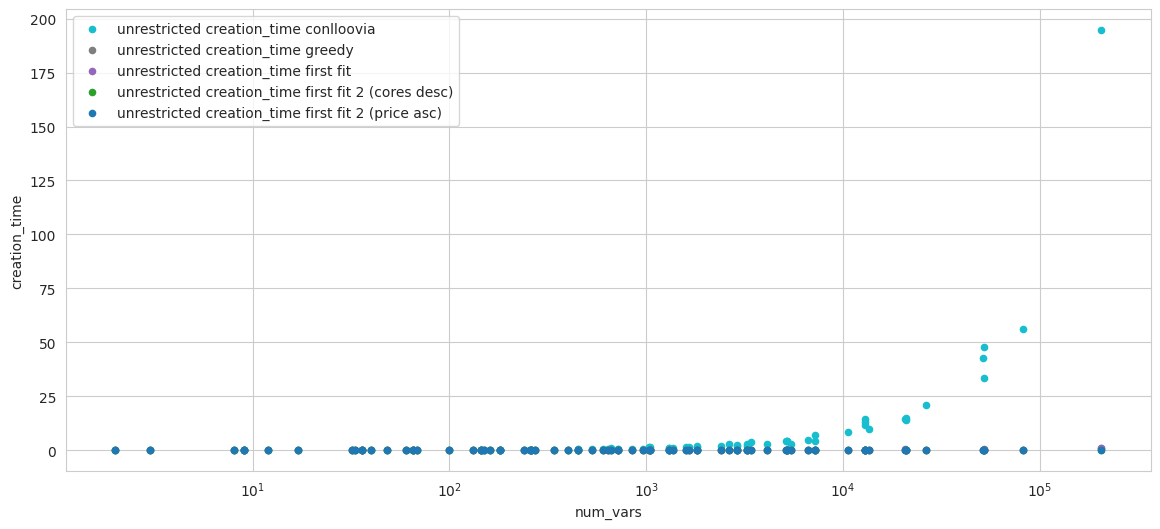

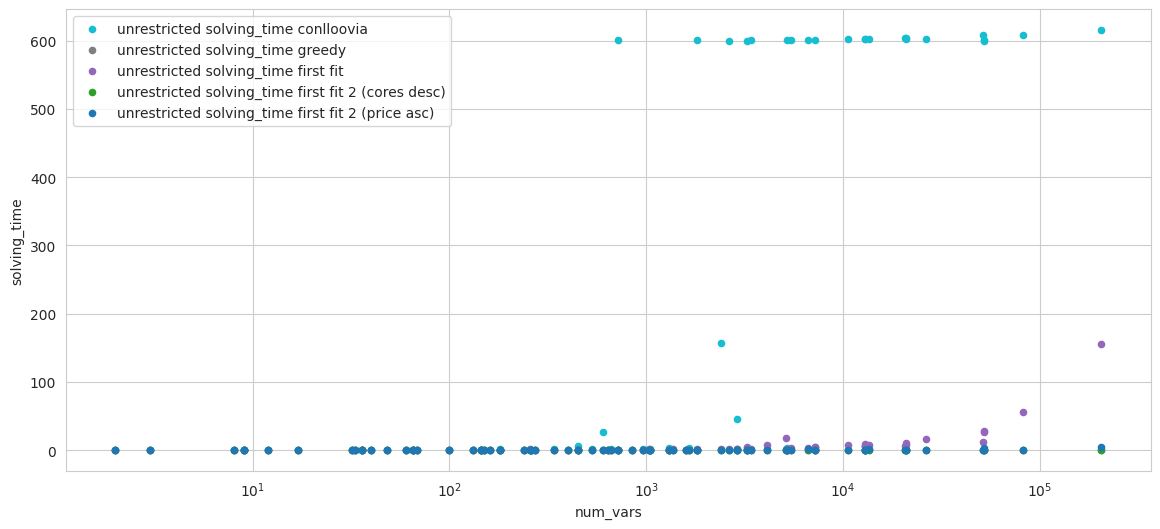

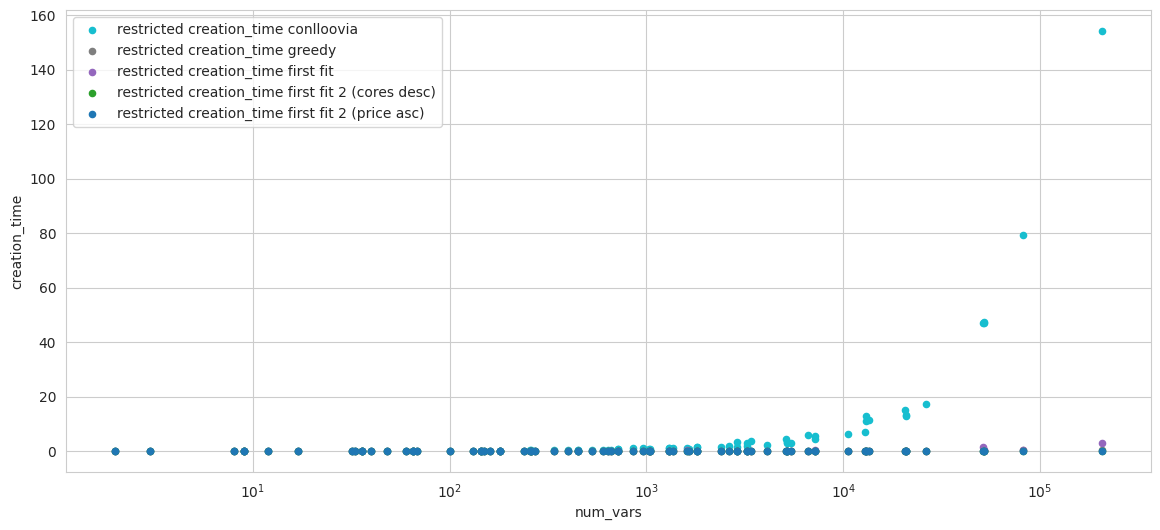

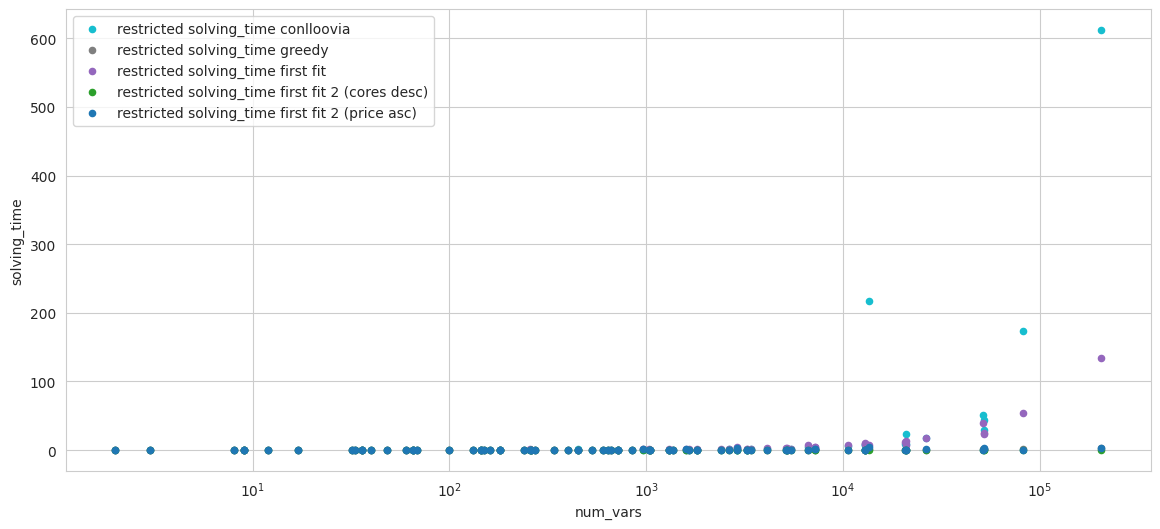

In [6]:
allocators = [
    "conlloovia",
    "greedy",
    "first fit",
    "first fit 2 (cores desc)",
    "first fit 2 (price asc)",
]
modes = ["unrestricted", "restricted"]
for mode in modes:
    for param in ["creation_time", "solving_time"]:
        color = iter(cm.tab10_r(np.linspace(0, 1, len(allocators))))
        fig, ax = plt.subplots(figsize=(14, 6))
        for allocator in allocators:
            df_stats_dict[mode][allocator].plot(
                x="num_vars",
                y=param,
                logx=True,
                kind="scatter",
                ax=ax,
                label=f"{mode} {param} {allocator}",
                color=next(color),
            )


In [7]:
# Pass to long form to be able to use seaborn
df_stats_long = {
    mode: df_stats_mode[mode].melt(id_vars=["exp", "num_vars", "status", "alloc"])
    for mode in modes
}


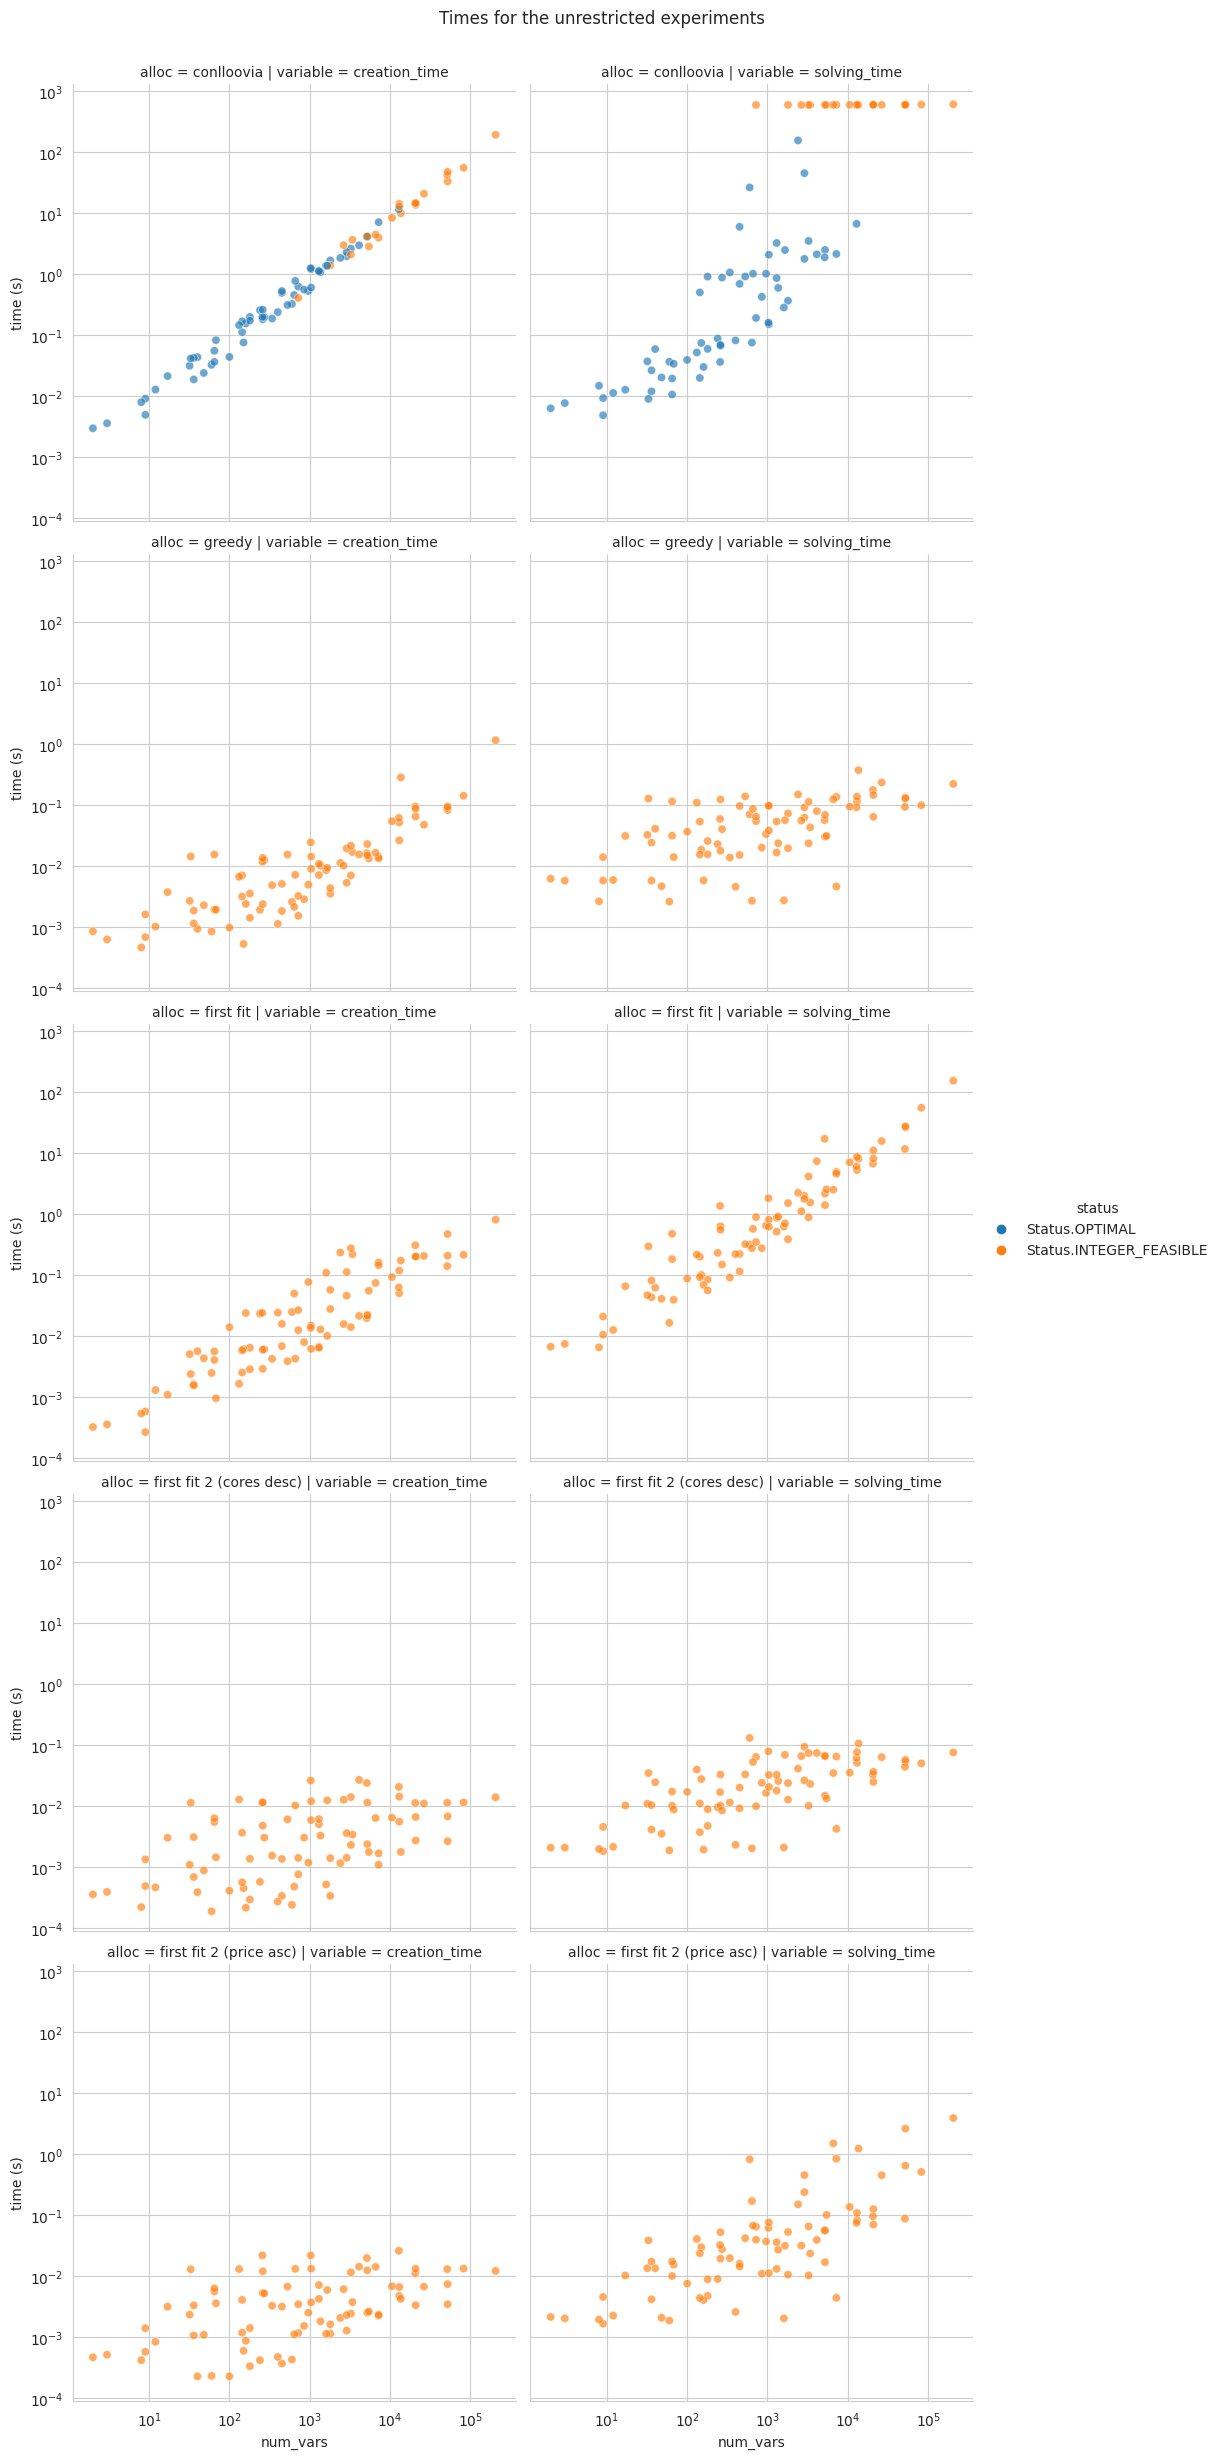

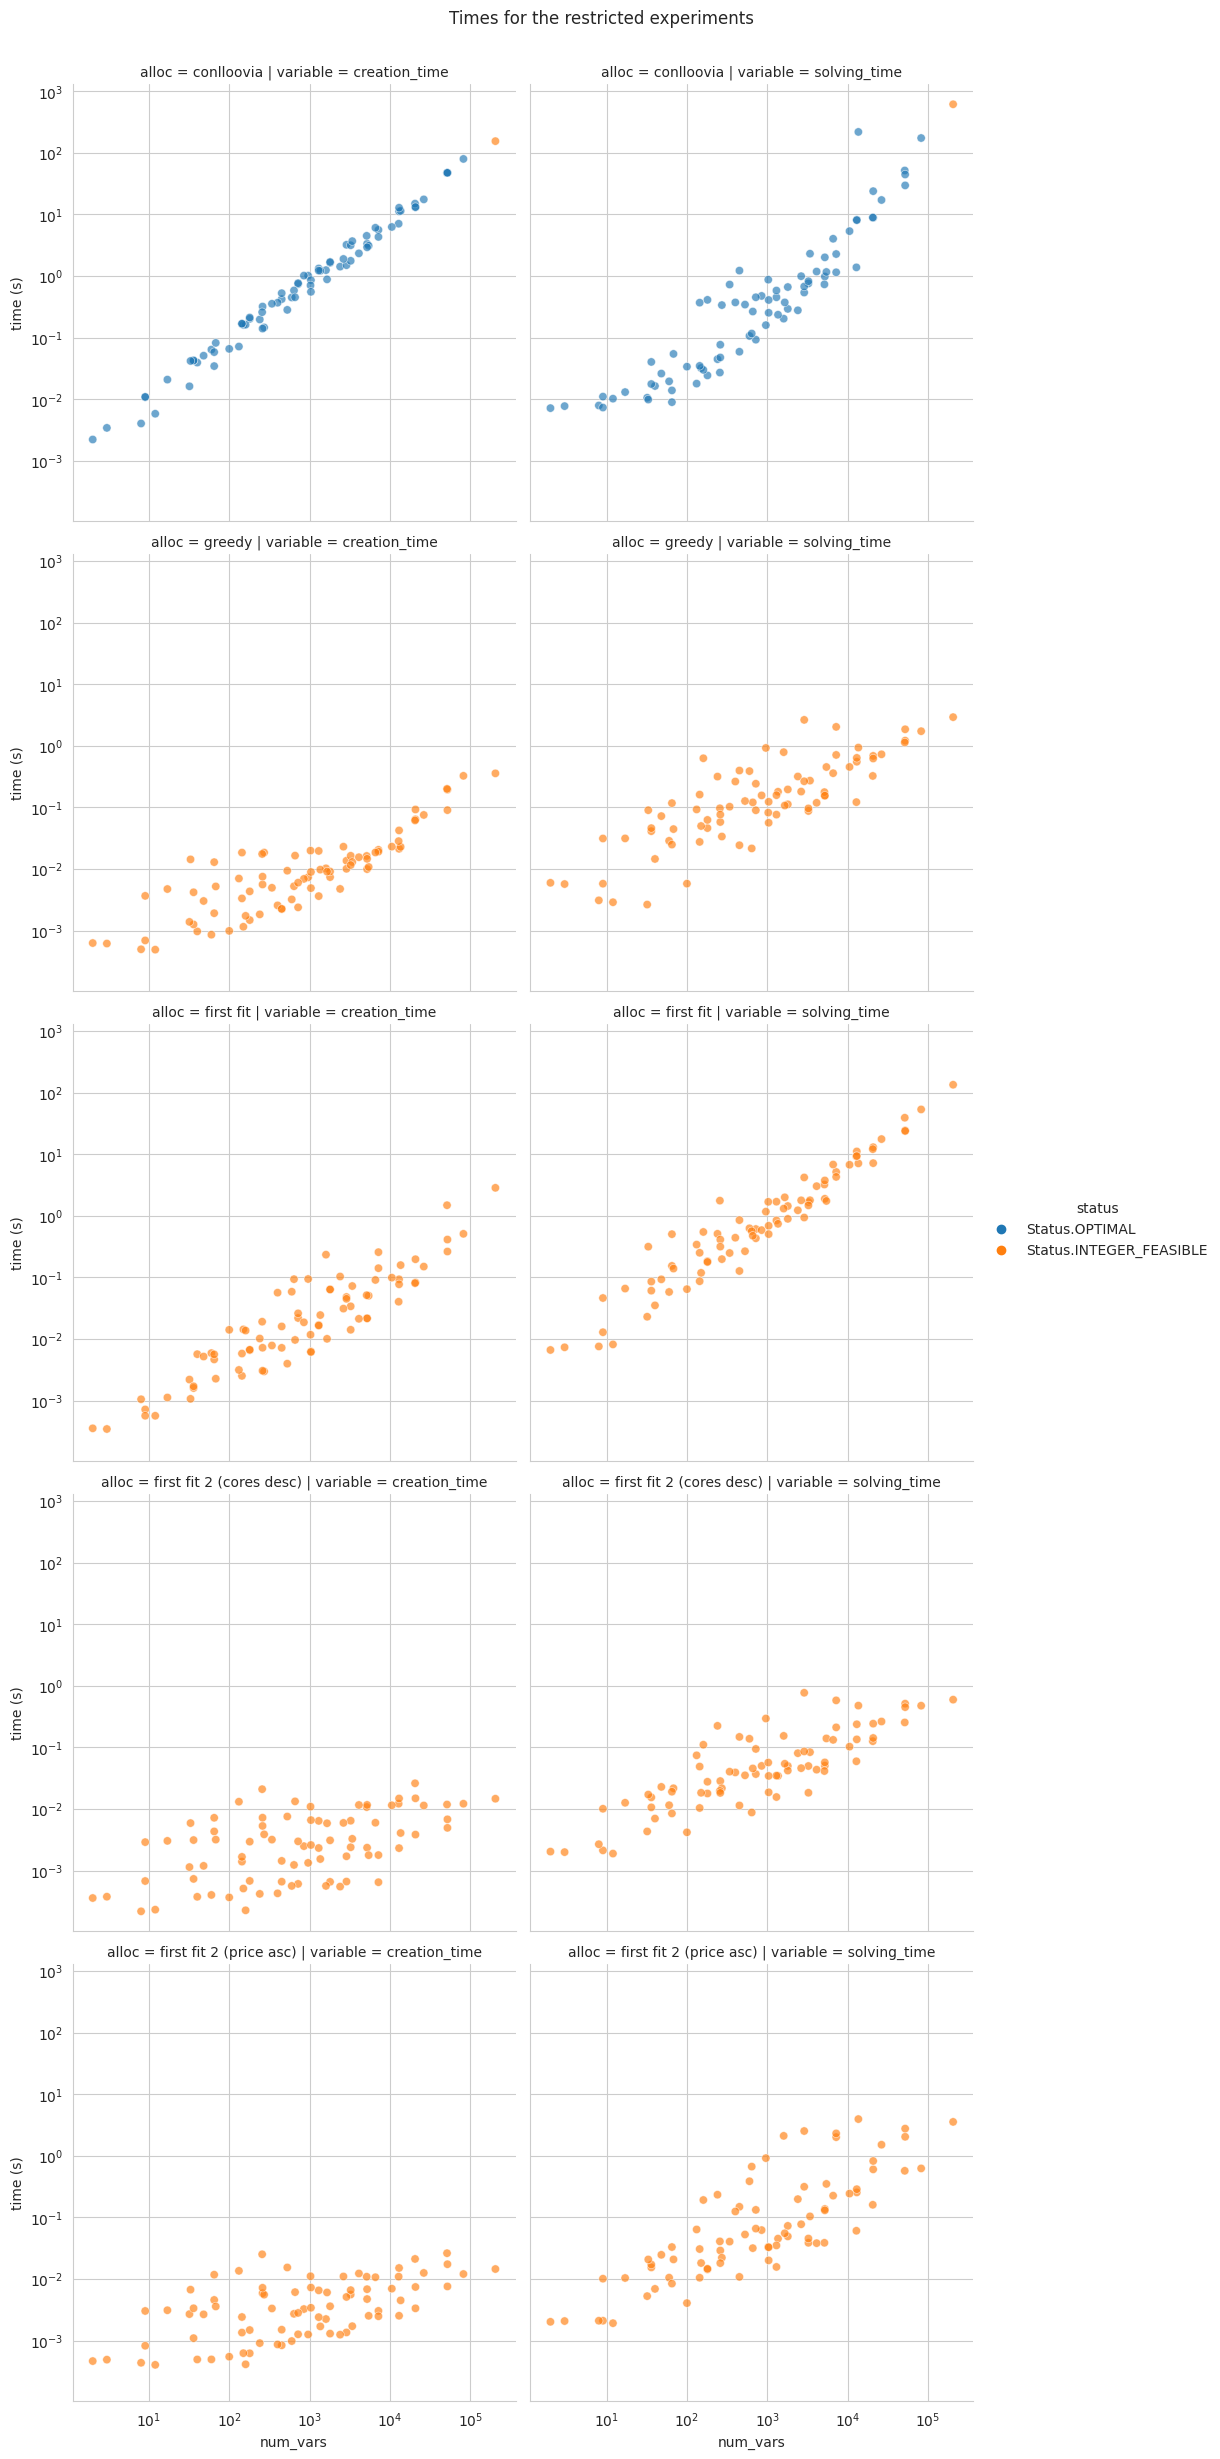

In [8]:
# Both axis using log scales. Notice that negative values not shown

# Plot a scatter plot with the creation and solving times for each mode
for mode in modes:
    # Select only the rows with the solving and creation times
    df_times = df_stats_long[mode][
        (df_stats_long[mode].variable == "solving_time")
        | (df_stats_long[mode].variable == "creation_time")
    ].rename(columns={"value": "time (s)"})

    g = sns.relplot(
        data=df_times,
        x="num_vars",
        y="time (s)",
        col="variable",
        row="alloc",
        hue="status",
        alpha=0.65,
    )
    g.set(xscale="log")
    g.set(yscale="log")
    g.fig.suptitle(f"Times for the {mode} experiments")
    g.fig.subplots_adjust(top=0.95)


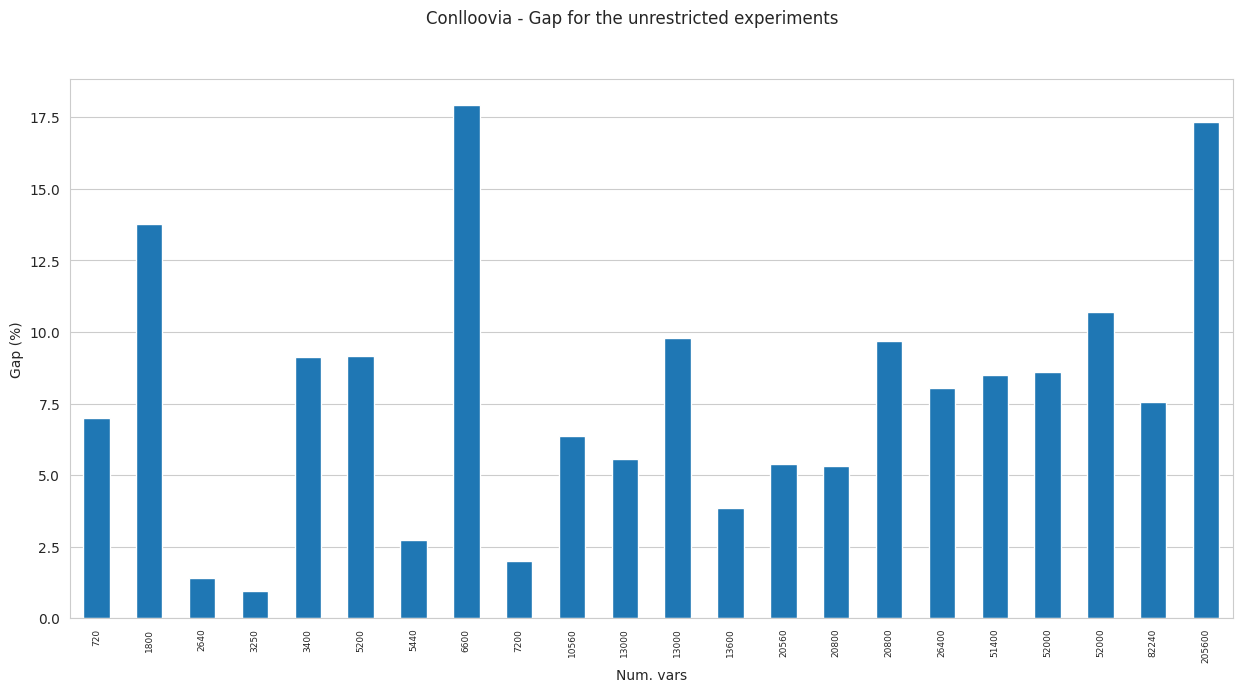

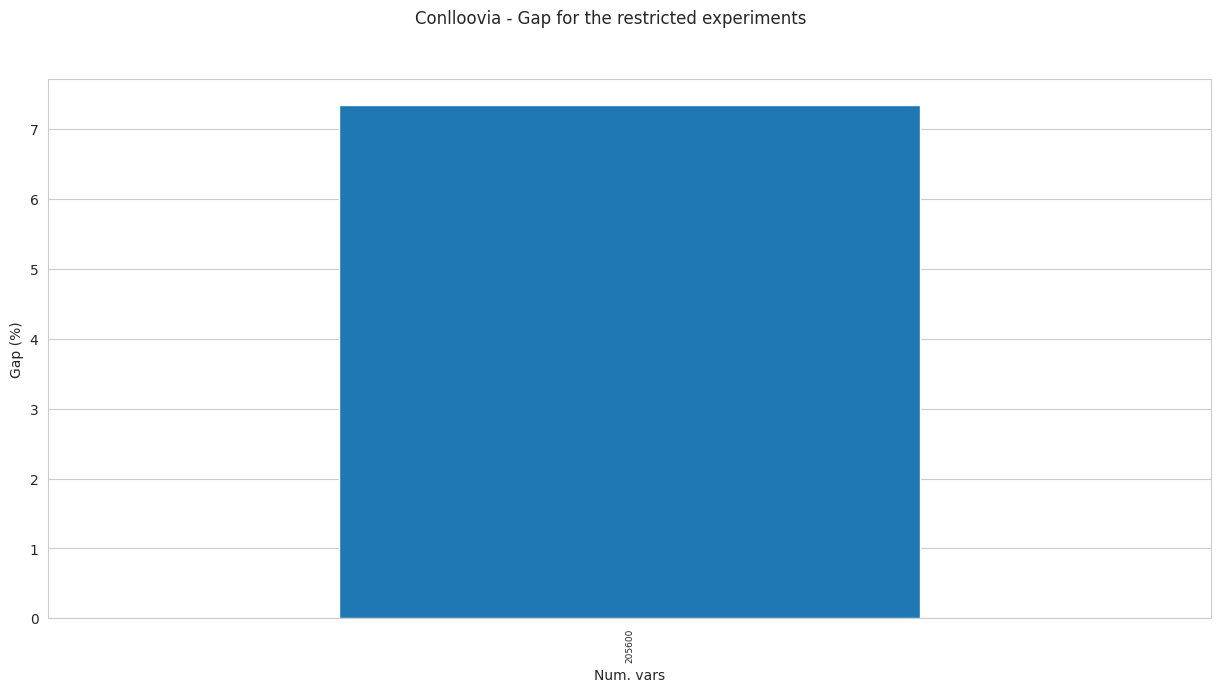

In [9]:
# Plot frac gap for conlloovia
for mode in modes:
    feasible_data = df_stats_dict[mode]["conlloovia"][
        df_stats_dict[mode]["conlloovia"].status == Status.INTEGER_FEASIBLE
    ]
    if not feasible_data.empty:
        fig, ax = plt.subplots(figsize=(15, 7))
        ax = feasible_data.sort_values(by="num_vars").plot(
            x="num_vars", y="gap_pct", kind="bar", legend=False, ax=ax
        )
        ax.set_ylabel("Gap (%)")
        ax.tick_params(
            axis="x", labelsize=6.5
        )  # setting the font size of x-tick labels to 10
        _ = ax.set_xlabel("Num. vars")
        _ = plt.grid(axis="x")
        fig.suptitle(f"Conlloovia - Gap for the {mode} experiments")


# Cost comparison

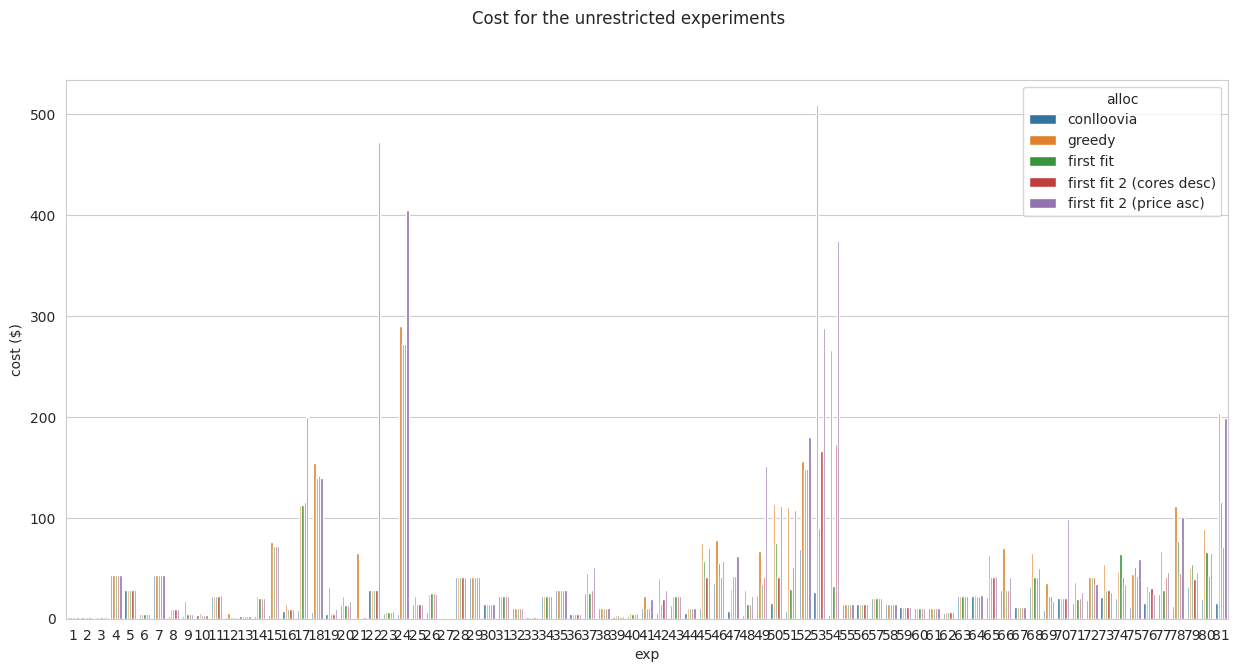

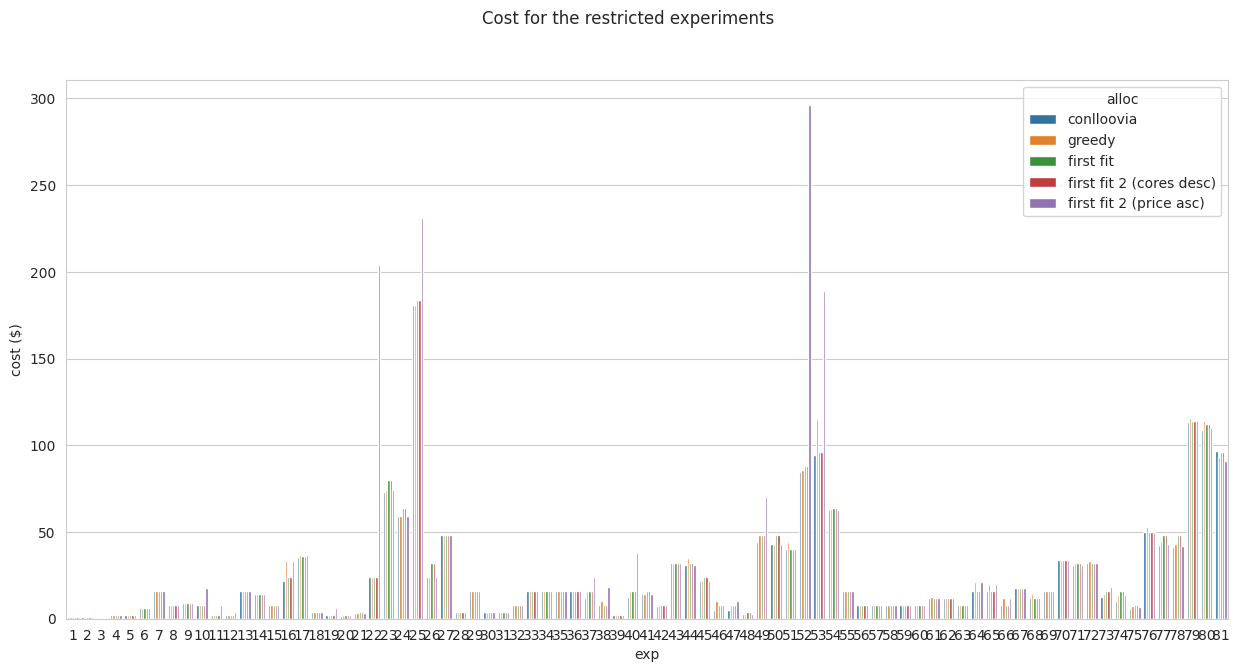

In [10]:
for mode in modes:
    df_costs = df_stats_long[mode][df_stats_long[mode].variable == "cost"].rename(
        columns={"value": "cost ($)"}
    )
    plt.figure(figsize=(15, 7))
    g = sns.barplot(data=df_costs, x="exp", y="cost ($)", hue="alloc")
    plt.suptitle(f"Cost for the {mode} experiments")


In [11]:
# Have the value of each column for the two allocators
df_stats_gr = {}
for mode in modes:
    df_stats_gr[mode] = df_stats_mode[mode].pivot(index="exp", columns=["alloc"])


In [12]:
# Print the number of experiments with each status for each allocator
for mode in modes:
    print(f"Status for the {mode} experiments")
    print(df_stats_gr[mode].status.apply(pd.value_counts).fillna(0))


Status for the unrestricted experiments

alloc                    conlloovia  first fit  first fit 2 (cores desc)  \
Status.OPTIMAL                   59        0.0                       0.0   
Status.INTEGER_FEASIBLE          22       81.0                      81.0   

alloc                    first fit 2 (price asc)  greedy  
Status.OPTIMAL                               0.0     0.0  
Status.INTEGER_FEASIBLE                     81.0    81.0

Status for the restricted experiments

alloc                    conlloovia  first fit  first fit 2 (cores desc)  \
Status.OPTIMAL                   80        0.0                       0.0   
Status.INTEGER_FEASIBLE           1       81.0                      81.0   

alloc                    first fit 2 (price asc)  greedy  
Status.OPTIMAL                               0.0     0.0  
Status.INTEGER_FEASIBLE                     81.0    81.0

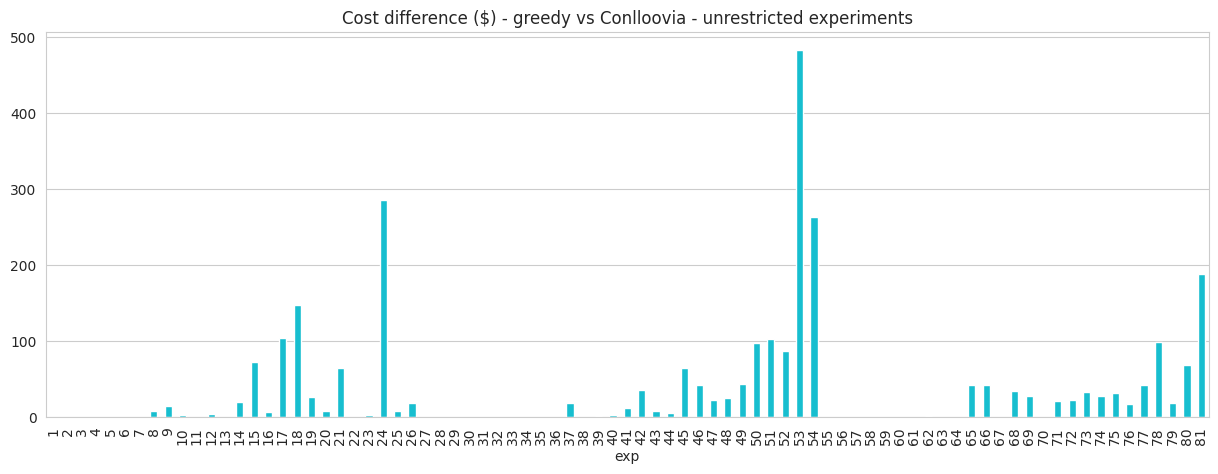

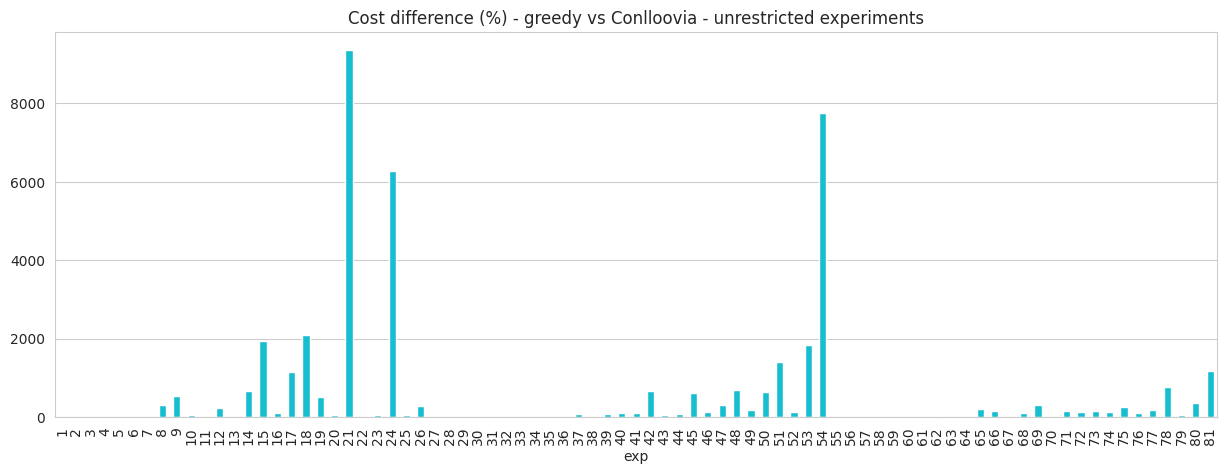

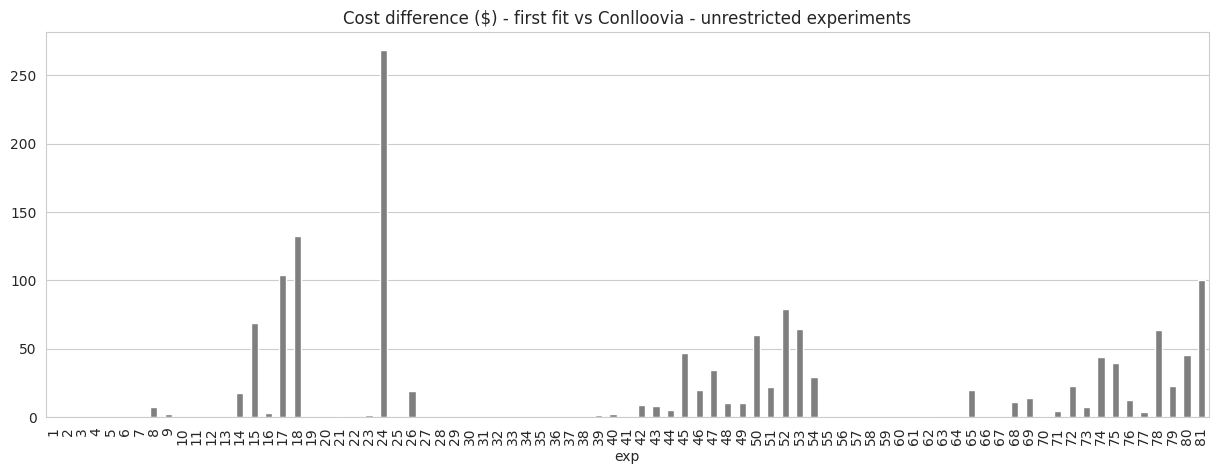

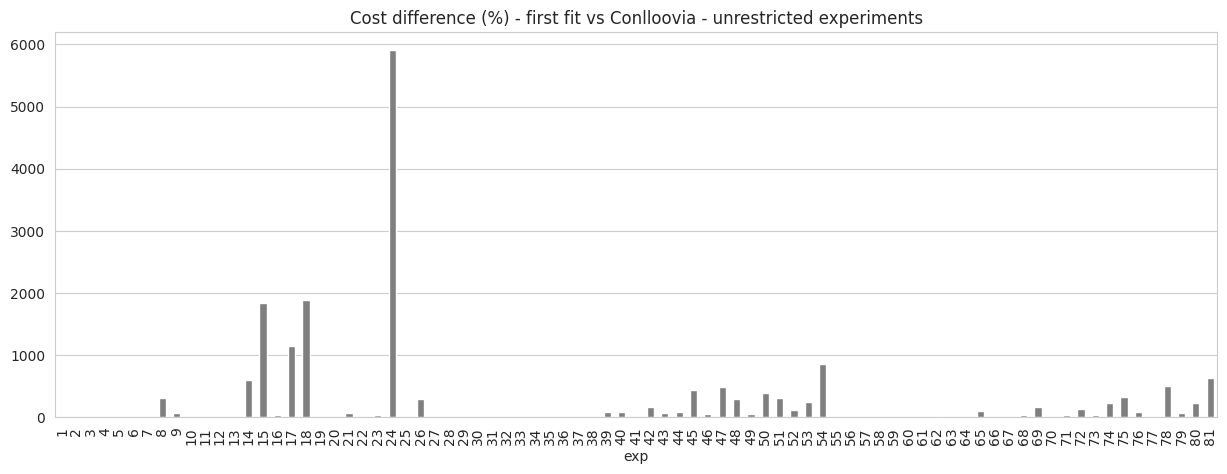

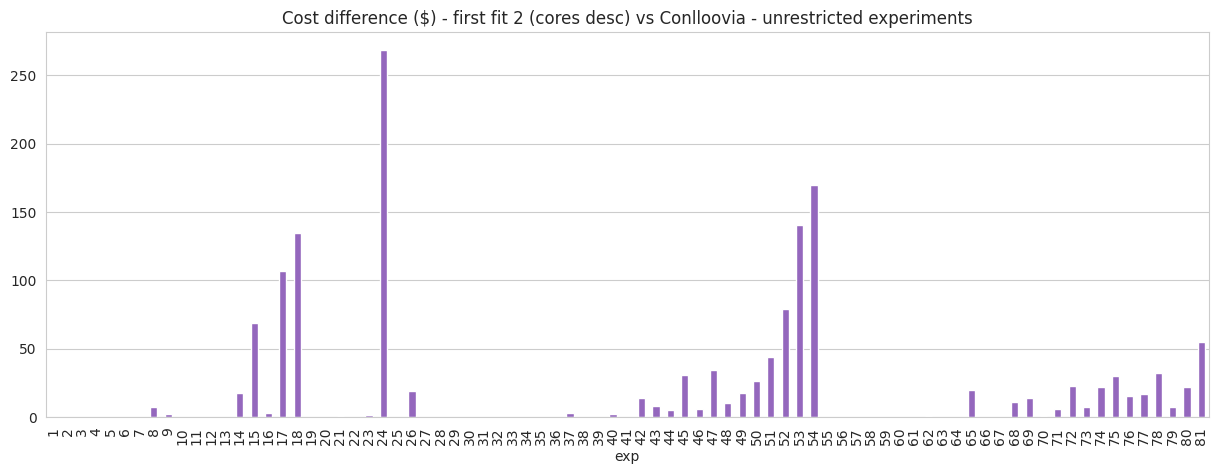

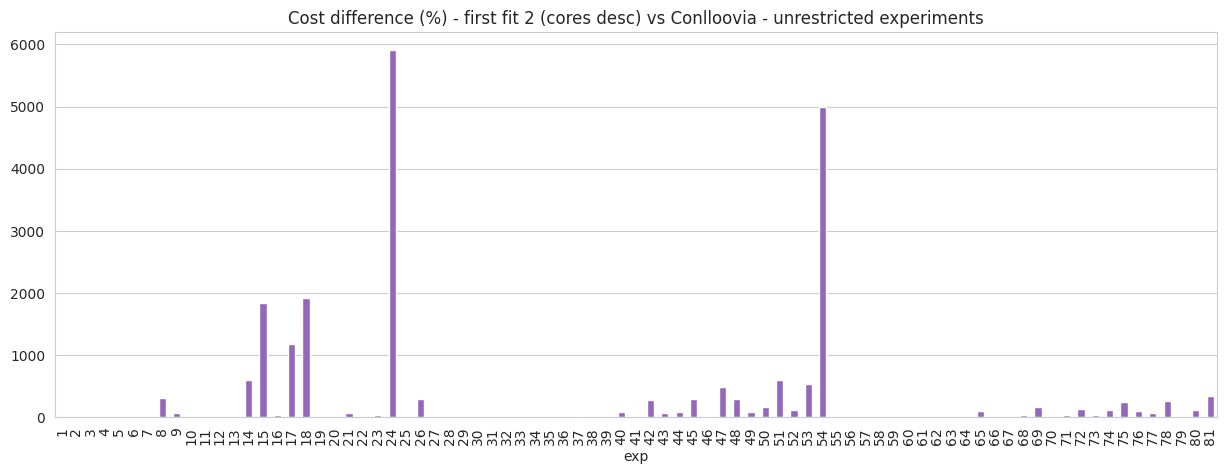

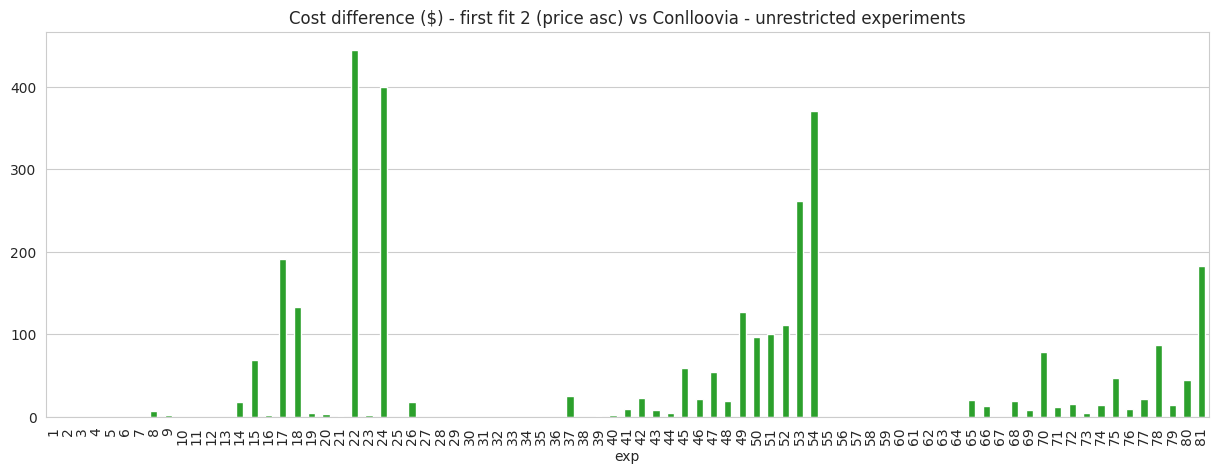

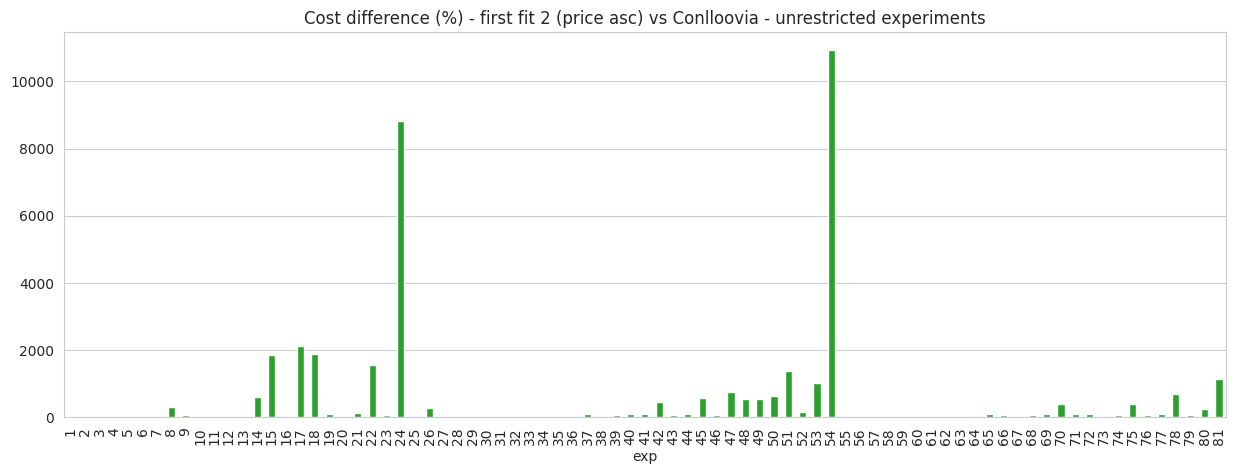

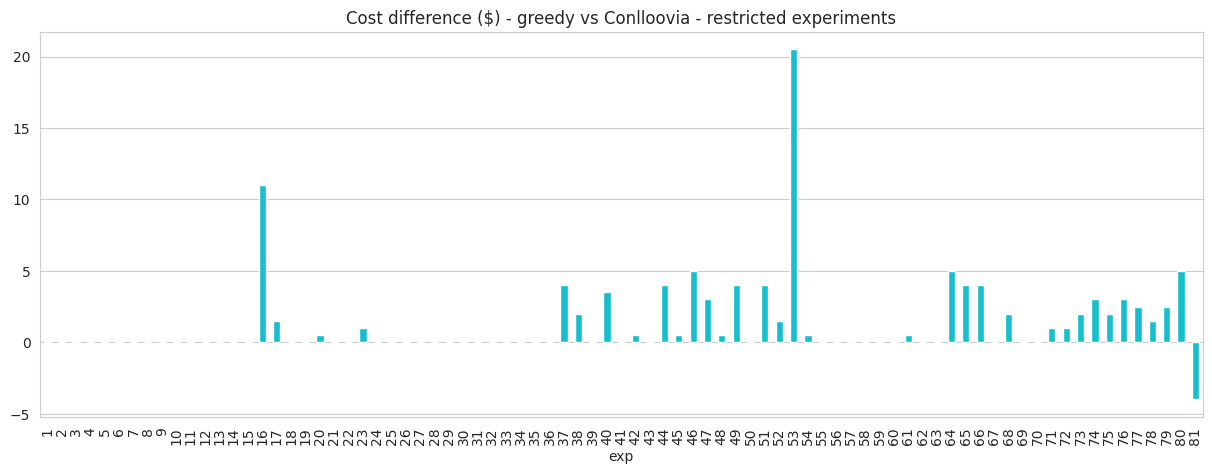

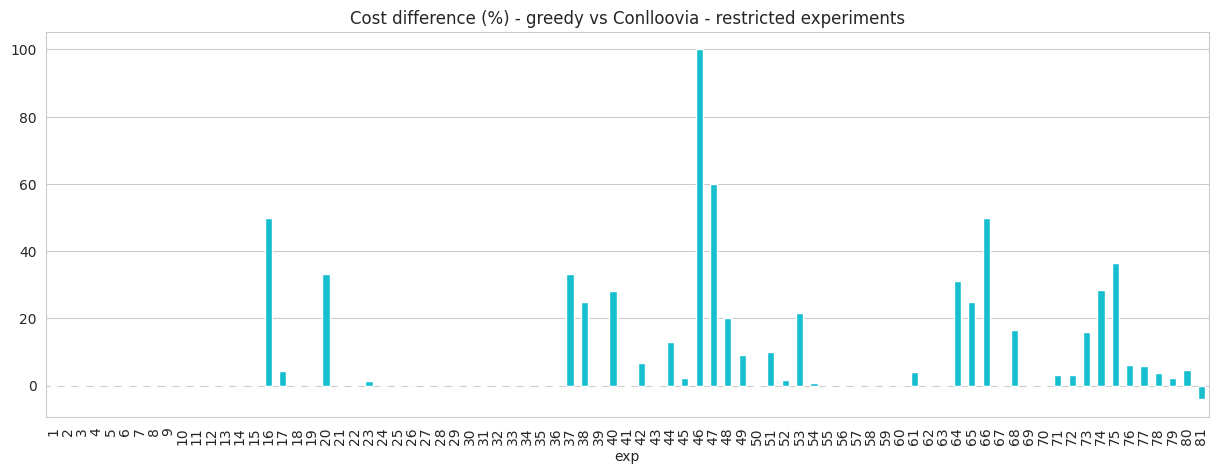

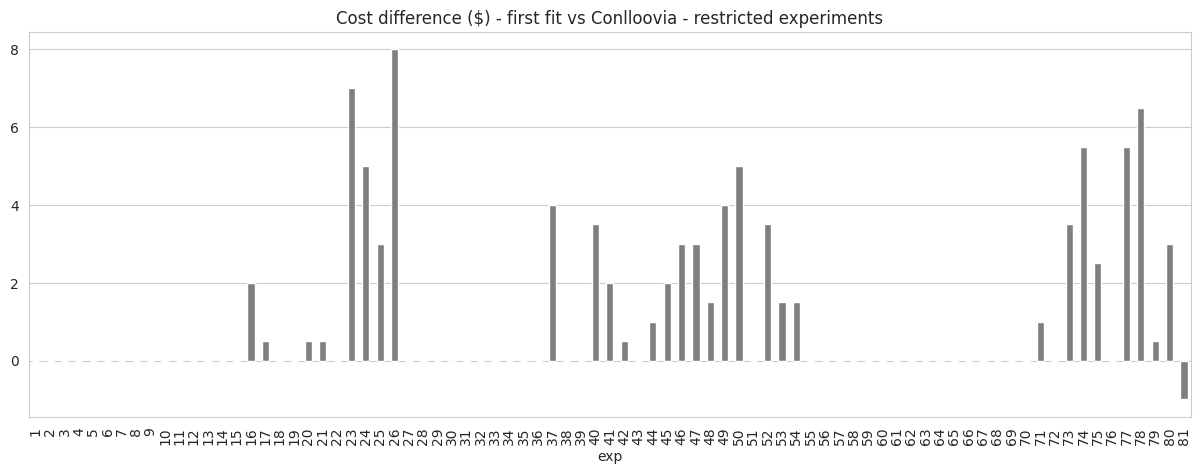

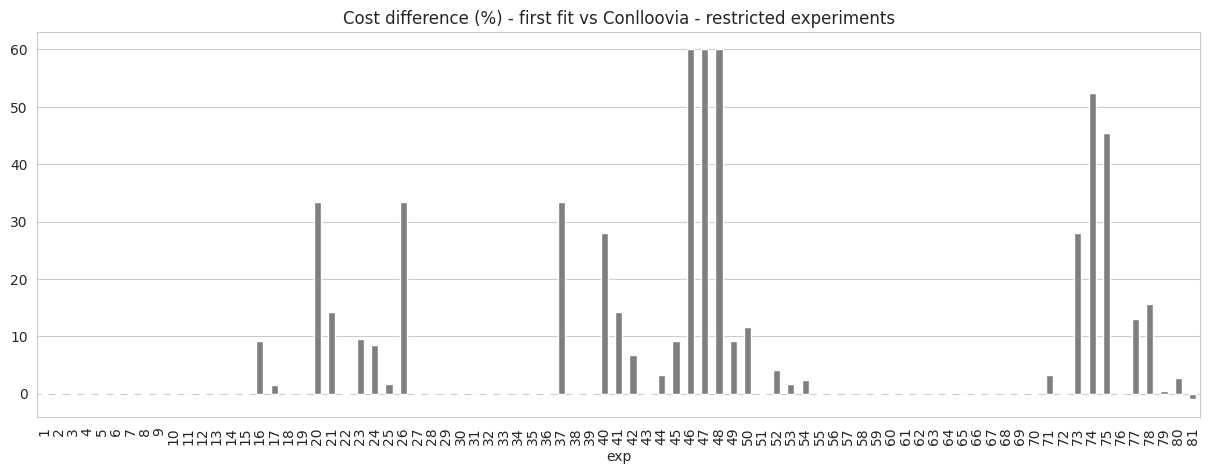

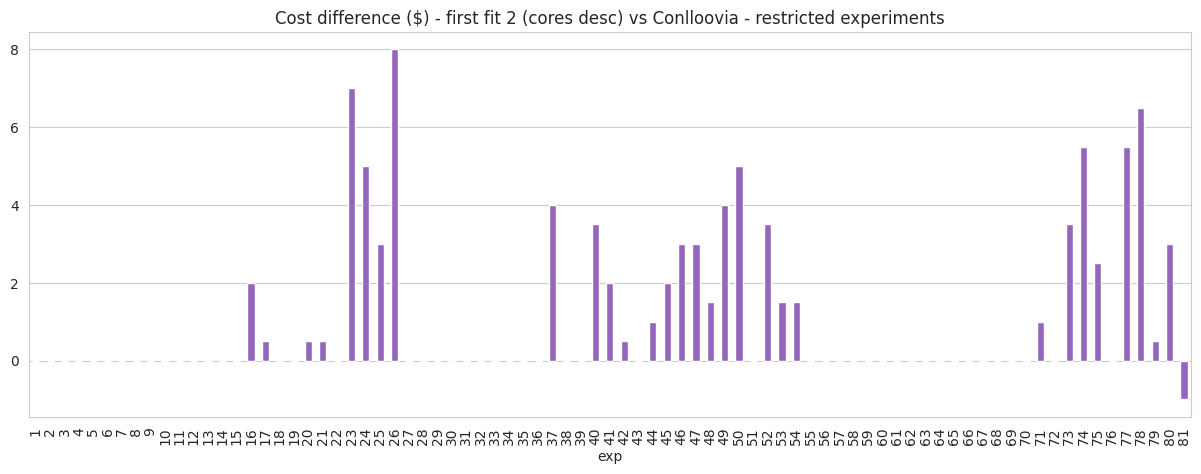

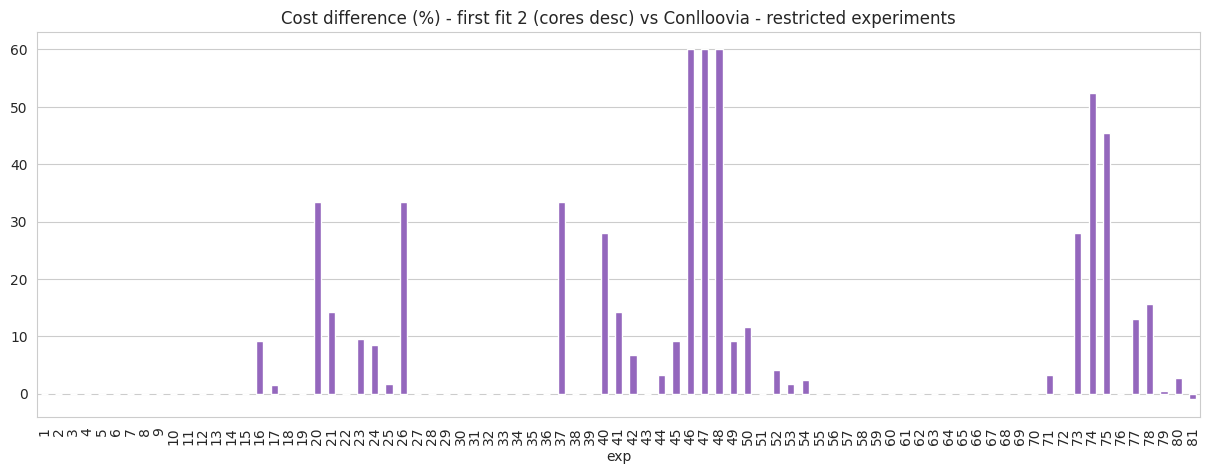

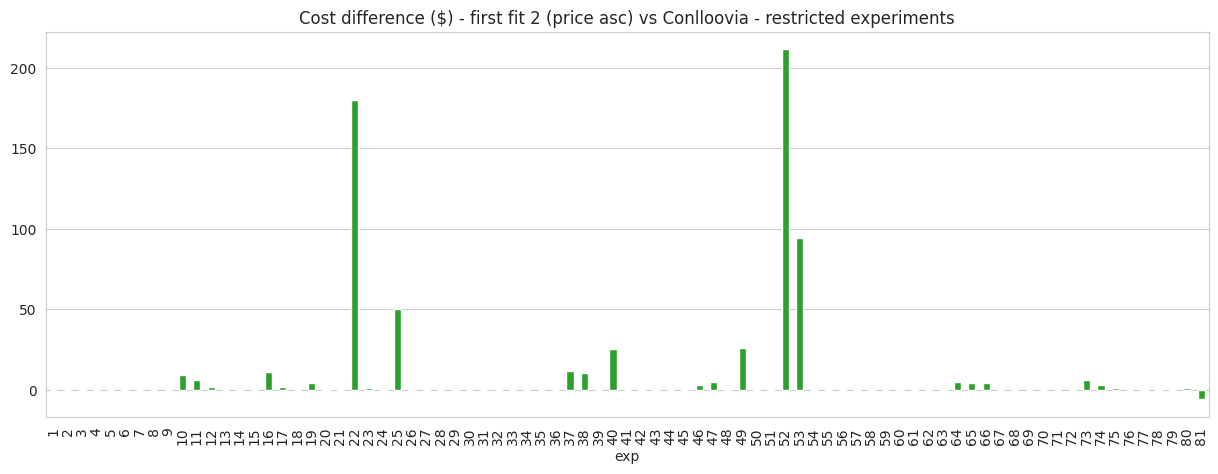

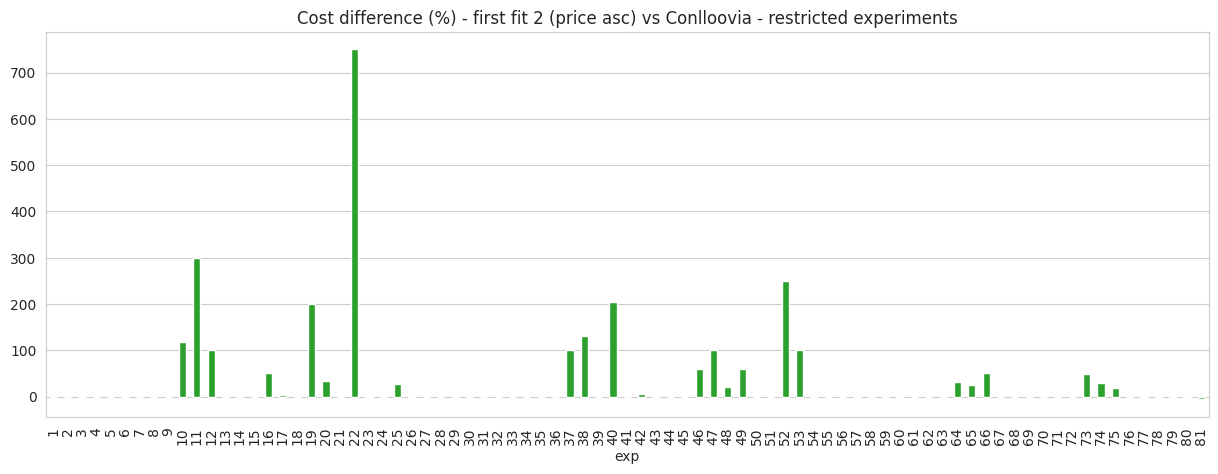

In [13]:
# Plot the difference with conlloovia of alll allocators, both in absolute and
# percentage terms. Show the difference only in the experiments where the
# heuristic finds a solution
for mode in modes:
    colors = iter(cm.tab10_r(np.linspace(0, 1, len(allocators))))
    for allocator in allocators:
        if allocator == "conlloovia":
            continue

        color = next(colors)

        # Compute the data (pct_change and diff)
        df_cost_diff = df_stats_gr[mode][
            df_stats_gr[mode].status[allocator] == Status.INTEGER_FEASIBLE
        ].cost.copy()
        df_cost_diff["pct_change"] = (
            df_cost_diff[["conlloovia", allocator]].pct_change(axis=1)[allocator] * 100
        )
        df_cost_diff["diff"] = df_cost_diff[allocator] - df_cost_diff.conlloovia

        # Plot the absolute change
        plt.figure()
        ax = df_cost_diff["diff"].plot(kind="bar", color=color, figsize=(15, 5))
        plt.title(
            f"Cost difference ($) - {allocator} vs Conlloovia - {mode} experiments"
        )
        plt.grid(axis="x")

        # Plot the percentage change
        plt.figure()
        ax = df_cost_diff["pct_change"].plot(kind="bar", color=color, figsize=(15, 5))
        plt.title(
            f"Cost difference (%) - {allocator} vs Conlloovia - {mode} experiments"
        )
        plt.grid(axis="x")


# Analysis of the maximum difference between conlloovia and first fit 2 cores desc

In [14]:
# Put in df_cost_diff the difference between the cost of conlloovia and first fit 2 cores desc
mode = "unrestricted"
allocator = "first fit 2 (cores desc)"
df_cost_diff = df_stats_gr[mode][
    df_stats_gr[mode].status[allocator] == Status.INTEGER_FEASIBLE
].cost.copy()
df_cost_diff["pct_change"] = (
    df_cost_diff[["conlloovia", allocator]].pct_change(axis=1)[allocator] * 100
)
df_cost_diff["diff"] = df_cost_diff[allocator] - df_cost_diff.conlloovia


# Find the experiment number with the biggest difference in percentage
max_diff_exp = df_cost_diff.sort_values(by="pct_change", ascending=False).head(1)
print(max_diff_exp)
max_diff_exp_num = max_diff_exp.index[0]


alloc conlloovia   first fit first fit 2 (cores desc) first fit 2 (price asc)  \
exp                                                                             
24      4.541988  272.753935               272.753935              404.767377   

alloc      greedy   pct_change        diff  
exp                                         
24     289.797402  5905.166264  268.211947

In [17]:
import pickle
from conlloovia.visualization import SolutionPrettyPrinter, ProblemPrettyPrinter

# Print the problem
ProblemPrettyPrinter(
    sols["unrestricted"]["conlloovia"][max_diff_exp_num].problem
).print()

# Save and print the solutions
for allocator in ["conlloovia", "first fit 2 (cores desc)"]:
    allocator_name = allocator.replace(" ", "_")
    with open(f"sols_exp_{max_diff_exp_num}_{allocator_name}.p", "wb") as f:
        sol = sols["unrestricted"][allocator][max_diff_exp_num]
        pickle.dump(sol, f)
        print(f"Solution for {allocator}")
        SolutionPrettyPrinter(sol).print()


                                 Instance classes                                 
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Instance class ┃   Cores ┃         Mem ┃                         Price ┃ Limit ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ ic_0           │  2 core │  8 gibibyte │  1.257814774108792 usd / hour │    20 │
│ ic_1           │ 16 core │ 64 gibibyte │ 10.677105486593433 usd / hour │    20 │
│ ic_2           │  4 core │  8 gibibyte │ 1.8536405921794672 usd / hour │    20 │
│ ic_3           │  4 core │ 16 gibibyte │ 2.7247259530771455 usd / hour │    20 │
│ ic_4           │  4 core │  8 gibibyte │  2.004031406079011 usd / hour │    20 │
│ ic_5           │  4 core │  4 gibibyte │ 1.7719708412047248 usd / hour │    20 │
│ ic_6           │ 32 core │ 32 gibibyte │ 11.232444886959488 usd / hour │    20 │
│ ic_7           │ 16 core │ 16 gibibyte │  5.465175096927348 usd / hour │    20 │
│ ic_8           │  8 core │ 32 gibibyte │  5.248640476427775 usd / hour │    20 │
│ ic_9           │  4 core │  4 gibibyte │  1.135497016043047 usd / hour │    20 │
│ ic_10          │ 16 core │ 16 gibibyte │  5.859391744578278 usd / hour │    20 │
│ ic_11          │ 16 core │ 64 gibibyte │ 10.317145563473092 usd / hour │    20 │
│ ic_12          │ 64 core │ 64 gibibyte │  22.29210787206838 usd / hour │    20 │
│ ic_13          │ 32 core │ 32 gibibyte │ 11.219821771629608 usd / hour │    20 │
│ ic_14          │  4 core │  8 gibibyte │ 1.8542483944478938 usd / hour │    20 │
│ ic_15          │  8 core │ 16 gibibyte │ 3.6725896898790498 usd / hour │    20 │
└────────────────┴─────────┴─────────────┴───────────────────────────────┴───────┘

                 Container classes                  
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Container class ┃    Cores ┃         Mem ┃ Limit ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ cc_app0_0       │   4 core │  4 gibibyte │ 128.0 │
│ cc_app0_1       │  16 core │  2 gibibyte │ 128.0 │
│ cc_app0_2       │  16 core │ 64 gibibyte │ 128.0 │
│ cc_app0_3       │ 1.5 core │  8 gibibyte │ 128.0 │
│ cc_app0_4       │  16 core │  8 gibibyte │ 128.0 │
│ cc_app0_5       │ 0.5 core │ 32 gibibyte │ 128.0 │
│ cc_app0_6       │  16 core │  8 gibibyte │ 128.0 │
│ cc_app0_7       │ 2.5 core │  2 gibibyte │ 128.0 │
└─────────────────┴──────────┴─────────────┴───────┘

              Apps              
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name ┃              Workload ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ app0 │ 23348147.0 req / hour │
└──────┴───────────────────────┘

                                      Performances                                       
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Instance class ┃ Container class ┃ App  ┃                RPS ┃ Price per million req. ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_0           │ cc_app0_0       │ app0 │  2079.764243280411 │                   0.17 │
│                │ cc_app0_1       │ app0 │   8319.81362603057 │                   0.04 │
│                │ cc_app0_2       │ app0 │  8316.562992662637 │                   0.04 │
│                │ cc_app0_3       │ app0 │  779.9701452719436 │                   0.45 │
│                │ cc_app0_4       │ app0 │   8323.56777201624 │                   0.04 │
│                │ cc_app0_5       │ app0 │ 260.02687922429453 │                   1.34 │
│                │ cc_app0_6       │ app0 │  8318.814885696765 │                   0.04 │
│                │ cc_app0_7       │ app0 │  1300.078583942522 │                   0.27 │
├────────────────┼─────────────────┼──────┼────────────────────┼────────────────────────┤
│ ic_1           │ cc_app0_0       │ app0 │ 2079.9000236120983 │                   1.43 │
│                │ cc_app0_1       │ app0 │  8318.979712426062 │                   0.36 │
│                │ cc_app0_2       │ app0 │  8320.485331554823 │                   0.36 │
│                │ cc_app0_3       │ app0 │  779.9655550660303 │                   3.80 │
│                │ cc_app0_4       │ app0 │  8318.718241708357 │                   0.36 │
│                │ cc_app0_5       │ app0 │  259.9980966530592 │                  11.41 │
│                │ cc_app0_6       │ app0 │  8320.414466399481 │                   0.36 │
│                │ cc_app0_7       │ app0 │ 1300.1969657238785 │                   2.28 │
├────────────────┼─────────────────┼──────┼────────────────────┼────────────────────────┤
│ ic_2           │ cc_app0_0       │ app0 │  2079.887469152561 │                   0.25 │
│                │ cc_app0_1       │ app0 │  8319.346360799356 │                   0.06 │
│                │ cc_app0_2       │ app0 │  8320.100526928232 │                   0.06 │
│                │ cc_app0_3       │ app0 │   779.981549047382 │                   0.66 │
│                │ cc_app0_4       │ app0 │   8318.62250951418 │                   0.06 │
│                │ cc_app0_5       │ app0 │  259.9620615095052 │                   1.98 │
│                │ cc_app0_6       │ app0 │  8316.922532514085 │                   0.06 │
│                │ cc_app0_7       │ app0 │ 1299.9393052090559 │                   0.40 │
├────────────────┼─────────────────┼──────┼────────────────────┼────────────────────────┤
│ ic_3           │ cc_app0_0       │ app0 │ 2079.6636446063094 │                   0.36 │
│                │ cc_app0_1       │ app0 │  8322.075729363492 │                   0.09 │
│                │ cc_app0_2       │ app0 │   8318.50489950646 │                   0.09 │
│                │ cc_app0_3       │ app0 │  780.0767019462667 │                   0.97 │
│                │ cc_app0_4       │ app0 │  8318.694802037748 │                   0.09 │
│                │ cc_app0_5       │ app0 │   260.008764700817 │                   2.91 │
│                │ cc_app0_6       │ app0 │  8319.771042753471 │                   0.09 │
│                │ cc_app0_7       │ app0 │ 1300.2379502663678 │                   0.58 │
├────────────────┼─────────────────┼──────┼────────────────────┼────────────────────────┤
│ ic_4           │ cc_app0_0       │ app0 │ 2079.5825218594778 │                   0.27 │
│                │ cc_app0_1       │ app0 │  8318.319899668983 │                   0.07 │
│                │ cc_app0_2       │ app0 │    8317.7572211371 │                   0.07 │
│                │ cc_app0_3       │ app0 │  780.1951728609649 │                   0.71 │
│                │ cc_app0_4       │ app

Solution for conlloovia

   VM allocation (only used VMs)    
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ VM       ┃                  Cost ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_9[3]  │ 1.135497016043047 usd │
│ ic_9[4]  │ 1.135497016043047 usd │
│ ic_9[13] │ 1.135497016043047 usd │
│ ic_9[15] │ 1.135497016043047 usd │
├──────────┼───────────────────────┤
│ total: 4 │ 4.541988064172188 usd │
└──────────┴───────────────────────┘

              Container allocation (only used VMs)               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ VM       ┃ Container      ┃ App  ┃                       Perf ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_9[3]  │ cc_app0_0 (x1) │ app0 │ 7491469.181691741 req (x1) │
├──────────┼────────────────┼──────┼────────────────────────────┤
│ ic_9[4]  │ cc_app0_0 (x1) │ app0 │ 7491469.181691741 req (x1) │
├──────────┼────────────────┼──────┼────────────────────────────┤
│ ic_9[13] │ cc_app0_0 (x1) │ app0 │ 7491469.181691741 req (x1) │
├──────────┼────────────────┼──────┼────────────────────────────┤
│ ic_9[15] │ cc_app0_0 (x1) │ app0 │ 7491469.181691741 req (x1) │
├──────────┼────────────────┼──────┼────────────────────────────┤
│ total: 4 │ 4              │      │     29965876.726766963 req │
└──────────┴────────────────┴──────┴────────────────────────────┘

Total cost: 4.541988064172188 usd

Solution for first fit 2 (cores desc)

    VM allocation (only used VMs)     
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ VM        ┃                   Cost ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_8[13]  │  5.248640476427775 usd │
│ ic_12[0]  │  22.29210787206838 usd │
│ ic_12[1]  │  22.29210787206838 usd │
│ ic_12[2]  │  22.29210787206838 usd │
│ ic_12[3]  │  22.29210787206838 usd │
│ ic_12[4]  │  22.29210787206838 usd │
│ ic_12[5]  │  22.29210787206838 usd │
│ ic_12[6]  │  22.29210787206838 usd │
│ ic_12[7]  │  22.29210787206838 usd │
│ ic_12[8]  │  22.29210787206838 usd │
│ ic_12[9]  │  22.29210787206838 usd │
│ ic_12[10] │  22.29210787206838 usd │
│ ic_12[11] │  22.29210787206838 usd │
├───────────┼────────────────────────┤
│ total: 13 │ 272.75393494124836 usd │
└───────────┴────────────────────────┘

               Container allocation (only used VMs)               
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ VM        ┃ Container      ┃ App  ┃                       Perf ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ic_8[13]  │ cc_app0_5 (x1) │ app0 │ 936076.1699787009 req (x1) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[0]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[1]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[2]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[3]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[4]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[5]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[6]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[7]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[8]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[9]  │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[10] │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ ic_12[11] │ cc_app0_5 (x2) │ app0 │ 935956.4874376068 req (x2) │
├───────────┼────────────────┼──────┼────────────────────────────┤
│ total: 13 │ 25             │      │     23399031.868481256 req │
└───────────┴────────────────┴──────┴────────────────────────────┘

Total cost: 272.75393494124836 usd